# nn_classification_v19 = _v17 + Enveloped Dataset Curating

# Notebook Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # !!! "=-1" Forces system to not use GPU (This can allow for simultaneous training via GPU and testing via CPU)

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

 
import tensorflow as tf
# Logging Verbosity
#   Level | Level for Humans | Level Description                  
#  -------|------------------|------------------------------------ 
#   0     | DEBUG            | [Default] Print all messages       
#   1     | INFO             | Filter out INFO messages           
#   2     | WARNING          | Filter out INFO & WARNING messages 
#   3     | ERROR            | Filter out all messages      
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.autograph.set_verbosity(3)
tf.get_logger().setLevel('ERROR') # Filter out INFO messages
tf.logging.set_verbosity(tf.logging.ERROR)  # or any {DEBUG, INFO, WARN, ERROR, FATAL}
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # or any {DEBUG, INFO, WARN, ERROR, FATAL}

import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, STATUS_FAIL

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import channels

import timeit
from timeit import default_timer as timer
from time import sleep
from tqdm import tnrange, tqdm_notebook
get_ipython().run_line_magic('matplotlib', 'notebook')

from IPython.core.debugger import set_trace
# import pixiedust # Visual Debugger

import data_utils_wlan_v03 as data_utils

print("TensorFlow version: ", tf.__version__)

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    
pickle = False

/home/gemoore/anaconda3/envs/tf_k_skl_p_gpu_191124/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gemoore/anaconda3/envs/tf_k_skl_p_gpu_191124/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gemoore/anaconda3/envs/tf_k_skl_p_gpu_191124/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

TensorFlow version:  1.14.0
Default GPU Device: /device:GPU:0


In [3]:
FOLDER_PATH = '/mnt/2ndSSD/802-11_datasets/wlan_enveloped'
DATA_PATH = FOLDER_PATH + '/data'
PROJECT_NAME = 'nn_classification'
VERSION = '_v19'

from datetime import datetime
NOW = datetime.utcnow().strftime("%Y%m%d%H%M%S")
ROOT_LOG_DIR = FOLDER_PATH + "/logs_" + PROJECT_NAME + VERSION
if not os.path.exists(ROOT_LOG_DIR):
    os.mkdir(ROOT_LOG_DIR)

# Tensorboard folders
LOGS_DIR = "{}/run-{}".format(ROOT_LOG_DIR,NOW)
if not os.path.exists(LOGS_DIR):
    os.mkdir(LOGS_DIR)

if not os.path.exists(LOGS_DIR + '/train'):
    os.mkdir(LOGS_DIR + '/train')
    
if not os.path.exists(LOGS_DIR + '/valid'):
    os.mkdir(LOGS_DIR + '/valid')

# Checkpoints folder
CHECKPOINTS_DIR = FOLDER_PATH + "/checkpoints_" + PROJECT_NAME + VERSION
if not os.path.exists(CHECKPOINTS_DIR):
    os.mkdir(CHECKPOINTS_DIR)
    
MODEL_FINAL_WEIGHTS_SAVE_PATH = FOLDER_PATH + '/' + PROJECT_NAME + VERSION + '_final_weights.h5'
MODEL_FINAL_SAVE_PATH = FOLDER_PATH + '/' + PROJECT_NAME + VERSION + '_final_model.h5'
MODEL_TFLITE_PATH = FOLDER_PATH + '/' + PROJECT_NAME + VERSION +'.tflite'
MODEL_TFLITE_QUANT_PATH = FOLDER_PATH + '/' + PROJECT_NAME + VERSION +'quantized.tflite'

# Calculate Dataset Limits

In [4]:
from os import listdir
from os.path import isfile, join
from fnmatch import fnmatch
import scipy.io as sio

def calculate_dataset_limits():
# Determining Maximum n_mat_samples_per_packet and Minimum n_mat_packets
#    so that the data tensor is large enough to hold even the longest signal
#    but no larger in height than the shortest packet count 

    n_packets = 2**16
    n_adc_samples = 0  
    padding_max = 0
    for filename in tqdm_notebook(sorted(listdir(DATA_PATH)),desc='Find Max #\
        ADC Samples and Min # Packet Samples Loop', leave=False):
        filepath = join(DATA_PATH, filename)
        if fnmatch(filepath, '*.mat'):
            dataDict = sio.loadmat(filepath, squeeze_me = True, struct_as_record=False)
            dataStruct = dataDict['Dataset']
            sig_list_ = np.transpose(dataStruct.signal)
            n_adc_samples_per_packet = np.size(sig_list_,1)
            padding = dataStruct.padding
            if n_adc_samples_per_packet > n_adc_samples:
                n_adc_samples = n_adc_samples_per_packet
            n_packet_samples = np.size(sig_list_,0)
            if n_packet_samples < n_packets and n_packet_samples != 6:
                n_packets = n_packet_samples
            if padding_max < padding:
                padding_max = padding
                print('Signal Padding: {}'.format(padding))
    return n_packets, n_adc_samples, padding_max

# Dataset Parameter Settings

In [5]:
n_matlab_protocols = 3 # 2 = g, n ; 3 = b, g, n
n_matlab_data_packet_types = 3
n_matlab_ctrl_packet_types = 6
n_matlab_packet_types = n_matlab_data_packet_types+n_matlab_ctrl_packet_types
n_matlab_center_freqs = 1
n_matlab_snrs = 1
n_matlab_downsamples = 3
n_matlab_mcss = 8
n_matlab_hts = 2

n_matlab_packets_min, n_matlab_adc_samples_per_packet_max, padding_max = calculate_dataset_limits()

# n_matlab_adc_samples_per_packet_max = 8032 # !!! Hard-coded for speed
# n_matlab_packets_min = 1998 #2000 # !!! Hard-coded for speed

N_PROTOCOLS = n_matlab_protocols 
RF_SIGNAL_LIST =  ['x', 'b', 'g', 'n'] # ['x', 'g', 'n']  # !!! Hard-coded for speeding up Debugging
N_RF_SIGNALS = len(RF_SIGNAL_LIST)

N_SNRS = n_matlab_snrs
PADDING = padding_max

N_DATA_PACKET_TYPES = n_matlab_data_packet_types
N_CTRL_PACKET_TYPES = n_matlab_ctrl_packet_types
N_PACKET_TYPES = N_DATA_PACKET_TYPES + N_CTRL_PACKET_TYPES
PACKET_TYPE_LIST = range(N_PACKET_TYPES)
N_PACKETS_PER_PACKET_TYPE = n_matlab_packets_min # 2000

N_DATASET_BLOCKS = 3
N_PACKETS_PER_BLOCK = int(N_PACKETS_PER_PACKET_TYPE/N_DATASET_BLOCKS)

N_ADC_SAMPLES = n_matlab_adc_samples_per_packet_max

N_CENTER_FREQS = n_matlab_center_freqs
N_SNRS = n_matlab_snrs
N_DOWNSAMPLES = n_matlab_downsamples
N_MCSS = n_matlab_mcss
N_HTS = n_matlab_hts

print("User Settings:")
print("  Maximum # of ADC Samples in Dataset = {}".format(N_ADC_SAMPLES))
print("  Minimum # of Packets per Packet Type = {}".format(N_PACKETS_PER_PACKET_TYPE))
print("  # of Packets per Block = {}".format(N_PACKETS_PER_BLOCK))

# Classification Type:
CLASSIFICATION_TYPE = 'protocolAndPacket' # 'protocol' #'address' #'protocolAndPacket'

if CLASSIFICATION_TYPE == 'protocol':
    N_CLASSIFICATIONS = N_RF_SIGNALS # Protocol Classification
elif CLASSIFICATION_TYPE == 'packet':
    N_CLASSIFICATIONS = N_RF_SIGNALS # Packet Type Classification
elif CLASSIFICATION_TYPE == 'protocolAndPacket':
    N_CLASSIFICATIONS = N_PROTOCOLS*N_PACKET_TYPES + 1 # Address Classification
elif CLASSIFICATION_TYPE == 'address':
    N_CLASSIFICATIONS = 99 # Address Classification
    
print('  Classification: {}| # of Classifications: {}\n'.format(CLASSIFICATION_TYPE, N_CLASSIFICATIONS))

/home/gemoore/anaconda3/envs/tf_k_skl_p_gpu_191124/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


Signal Padding: 60
User Settings:
  Maximum # of ADC Samples in Dataset = 7952
  Minimum # of Packets per Packet Type = 1876
  # of Packets per Block = 625
  Classification: protocolAndPacket| # of Classifications: 28



# Setup Plot Envelope

In [6]:
def plot_envelope(data, class_idx=2**8-1, data_rate=0, data_len=2048,\
                  signal_name='NA', descriptor = '',\
                  classification_type ='address', y_axis_label='v',\
                  y_max=2.0, x_max=7832):    

    if signal_name == 'NA':                   
        if classification_type == 'protocol':
            signal_name = data_utils.convert_idx_to_rf_signal_name(\
                RF_SIGNAL_LIST, class_idx)
        elif classification_type == 'packet':
            signal_name = data_utils.convert_idx_to_packet_name(\
                RF_SIGNAL_LIST, class_idx)
        elif classification_type == 'protocolAndPacket':
            signal_name = data_utils.convert_idx_to_protocol_and_packet_name(\
                RF_SIGNAL_LIST, class_idx)
        elif classification_type == 'address':
            signal_name = data_utils.convert_idx_to_address(\
                RF_SIGNAL_LIST, class_idx)
        else:
           raise Exception('[{}] is not a valid classification_type'\
                           .format(classification_type))
    
    if y_axis_label == 'v':
        y_label = 'Amplitude (V)'
    elif y_axis_label == 'adc':
        y_label = 'Amplitude (ADC Counts)'
    else:
       raise Exception('[{}] is not a valid Y Label'.format(y_axis_label))
    
    
    plt.plot(data)
    plt.title('{} - {}\nClass: {}| MCS: {}| Length: {} adc_samples'.\
              format(descriptor, signal_name, class_idx, data_rate, int(data_len)))
    plt.xlabel('Samples')
    plt.ylabel(y_label)
    plt.ylim((-0.01*y_max, y_max*1.01))
    plt.xlim((-0.01*x_max, x_max*1.01))
    #     plt.xlim((-0.01*x_max, x_max*.01))




# *.mat to *.p

In [ ]:
# Note: This is compatible with data produced after 2019-10-25
from os import listdir
from os.path import isfile, join
from fnmatch import fnmatch
import scipy.io as sio
import heapq

# N_PACKETS_PER_PACKET_TYPE, N_ADC_SAMPLES, PADDING_MAX = calculate_dataset_limits()
N_PACKETS_PER_BLOCK = int(N_PACKETS_PER_PACKET_TYPE/N_DATASET_BLOCKS)
print("Maximum # of ADC Samples in Dataset = {}".format(N_ADC_SAMPLES))
print("Minimum # of Packets per Packet Type = {}".format(N_PACKETS_PER_PACKET_TYPE))
print("# of Packets per Block = {}".format(N_PACKETS_PER_BLOCK))

sig_avg_max_list = []

for block in tnrange(N_DATASET_BLOCKS):
    for downsample_idx in tnrange(N_DOWNSAMPLES, desc='Downsample Loop', leave=False):
        # Looping through each of the downsample ratios (1x, 2x, 4x)
        n_downsamples_per_pickle = 1
        data = (np.ones([N_PROTOCOLS, N_PACKET_TYPES, N_CENTER_FREQS,\
                         n_downsamples_per_pickle, N_SNRS, N_MCSS,\
                         N_PACKETS_PER_BLOCK, N_ADC_SAMPLES],\
                         dtype=np.uint16)*int(2**16-1)).astype(np.int16)
        print("Data Tensor Shape = {}".format(data.shape))
        data_features = (np.ones([N_PROTOCOLS, N_PACKET_TYPES,\
                                  N_CENTER_FREQS, n_downsamples_per_pickle,\
                                  N_SNRS, N_MCSS, 11], dtype=np.uint16)*\
                                  int(2**16-1)).astype(np.uint16)
             # [center_freq_, snr_, downsample_ratio_, mcs_, data_rate_, ht_, n_samples_per_packet_temp]

        for filename in tqdm_notebook(sorted(listdir(DATA_PATH)),desc='File Open Loop', leave=False):
            filepath = join(DATA_PATH, filename)
            if fnmatch(filepath, '*.mat'):        
                # Opening the *.mat
                dataDict = sio.loadmat(filepath, squeeze_me = True, struct_as_record=False)
                dataStruct = dataDict['Dataset']        

                sig_list = np.transpose(dataStruct.signal)
                if np.size(sig_list,0) < N_PACKETS_PER_BLOCK:
                    n_packets = np.size(sig_list,0)
                else:
                    n_packets = N_PACKETS_PER_BLOCK # np.size(sig_list,0) # dataStruct.num_packets
                    
                packet_type_list = dataStruct.packetType
                snr_list = dataStruct.snr
                n_samples_list = dataStruct.numSamples
                downsample_ratio_list = dataStruct.downsampleRate
                packet_n_list = dataStruct.packetNo
                std_802p11_list = np.tile(dataStruct.standard, N_PACKETS_PER_PACKET_TYPE)
                center_freq_list = np.tile(dataStruct.center_freq, N_PACKETS_PER_PACKET_TYPE)
                mcs_list = np.tile((dataStruct.mcs).split('S')[1], N_PACKETS_PER_PACKET_TYPE)
                mcs_list2 = np.tile(filename.split('_')[9][-1], N_PACKETS_PER_PACKET_TYPE) # mcs_list = dataStruct.mcs
                if mcs_list[0] != mcs_list2[0]:
                    set_trace()
                
                ht_list = np.tile(dataStruct.ht, N_PACKETS_PER_PACKET_TYPE)
                data_rate_list = np.tile(dataStruct.dataRate, N_PACKETS_PER_PACKET_TYPE)
                padding_list = np.tile(dataStruct.padding, N_PACKETS_PER_PACKET_TYPE)
                if dataStruct.padding != 60:
                    print(filename)
                    print('Padding: {}'.format(dataStruct.padding))
                    set_trace()
                address_list = np.tile(2**8-1, N_PACKETS_PER_PACKET_TYPE) #!!! Replace eventually
                if data_utils.convert_downsample_to_idx(\
                                     downsample_ratio_list[0]) != downsample_idx:
                    continue # !!! Note: this is inefficient but the data set isn't so large that it
                             #       matters at the moment

                print("\n" + filename)

                # Scaling and quantizing the signal
                n_largest = 440
#                 for sig_idx in range(np.size(sig_list,0)):
#                     # Determining the Avg max Vpeak
#                     avg_max = np.mean(heapq.nlargest(n_largest, sig_list[sig_idx,:]))
#                     sig_avg_max_list.append(avg_max)
                scaling_target_v = 1.0
                adc_resolution = 14
                adc_v_ref = 2.0
                env_sig = data_utils.scale_and_quantize_sig(sig_list, n_largest,\
                    scaling_target_v, adc_resolution, adc_v_ref)

                # Parsing out Packet Type
                packet_type_of_4 = filename.split('_')[12]            
                for packet_per_block_idx in tnrange(n_packets, desc='Packet Sample Loop'):
                    if packet_type_of_4 == 'Control':
                        packet_idx = packet_per_block_idx
                    else:
                        packet_idx_offset = int(block*n_packets)
                        packet_idx = packet_idx_offset + packet_per_block_idx
                        
                    packet_type_idx = data_utils.convert_packet_type_to_idx(\
                        packet_type_list[packet_idx])
                    packet_length = n_samples_list[packet_idx]\
                        + 2*padding_list[packet_idx]
                    std_idx = data_utils.convert_std_to_idx(\
                        std_802p11_list[packet_idx])-1 # Not pickling Noise
                    center_freq_idx = data_utils.convert_center_freq_to_idx(\
                        center_freq_list[packet_idx])
                    ds_ratio_idx = 0
                        #data_utils.convert_downsample_to_idx(downsample_ratio_list[packet_idx])
                    snr_idx = data_utils.convert_snr_to_idx(\
                        snr_list[packet_idx])
                    mcs_idx = data_utils.convert_mcs_and_data_rate_to_idx(\
                        mcs_list[packet_idx], data_rate_list[packet_idx])

                    if packet_type_of_4 == 'Control':                        
                        # If packet is of Control type, then np.tile the results\
                        #   to fill the full the N_PACKETS_PER_BLOCK 
                        data[std_idx, packet_type_idx, center_freq_idx, ds_ratio_idx,\
                             snr_idx, mcs_idx, :, 0:packet_length] =\
                            np.tile(env_sig[packet_idx, 0:packet_length],\
                                    (N_PACKETS_PER_BLOCK,1))
                        if std_802p11_list[packet_idx] == 'b':
                            # There are only 4 802.11b data_rates, as compared to\
                            #   8 MCS Levels, so we duplicate the 802.11b packets
                            data[std_idx, packet_type_idx, center_freq_idx,\
                                 ds_ratio_idx, snr_idx, mcs_idx+4, :, :] =\
                                data[std_idx, packet_type_idx, center_freq_idx,\
                                     ds_ratio_idx, snr_idx, mcs_idx, :, :]
                    else:
                        # There are enough packets recorded to fill the n_packets
                        data[std_idx, packet_type_idx, center_freq_idx, ds_ratio_idx,\
                             snr_idx, mcs_idx,0:n_packets, 0:packet_length] =\
                                env_sig[packet_idx_offset:packet_idx_offset+n_packets, 0:packet_length]
                        if std_802p11_list[packet_idx] == 'b':
                            # There are only 4 802.11b data_rates, as compared to\
                            #   8 MCS Levels, so we duplicate the 802.11b packets
                            data[std_idx, packet_type_idx, center_freq_idx,\
                                 ds_ratio_idx, snr_idx, mcs_idx+4, :, :] =\
                                data[std_idx, packet_type_idx, center_freq_idx,\
                                     ds_ratio_idx, snr_idx, mcs_idx, :, :]
                    std_0 = std_802p11_list[packet_idx]
                    std_idx_including_noise = data_utils.convert_std_to_idx(std_0)
                    packet_type_0 = packet_type_list[packet_idx]
                    std_and_packet_type_0 = data_utils.\
                        convert_std_and_packet_type_to_idx(RF_SIGNAL_LIST,\
                           std_idx_including_noise, packet_type_0)
                    center_freq_0 = center_freq_list[packet_idx]
                    snr_0 = snr_list[packet_idx]
                    ds_ratio_0 = downsample_ratio_list[packet_idx]
                    data_rate_0 = data_rate_list[packet_idx]      
                    mcs_0 = data_utils.convert_mcs_and_data_rate_to_idx(\
                           mcs_list[packet_idx],data_rate_0) 
                    ht_0 = ht_list[packet_idx]
                    address_0 = address_list[packet_idx]

                    data_features[std_idx, packet_type_idx, center_freq_idx,\
                                  ds_ratio_idx, snr_idx, mcs_idx,:] =\
                        [std_idx_including_noise, packet_type_idx, std_and_packet_type_0,\
                         center_freq_0, snr_0, ds_ratio_0, mcs_0, data_rate_0, ht_0,\
                         address_0, n_samples_list[packet_idx]]
                    if std_0 == 'b':
                        # There are only 4 802.11b data_rates, as compared to\
                            #   8 MCS Levels, so we duplicate the 802.11b packets
                        data_features[std_idx, packet_type_idx, center_freq_idx,\
                                  ds_ratio_idx, snr_idx, mcs_idx+4,:] =\
                        [std_idx_including_noise, packet_type_idx, std_and_packet_type_0,\
                         center_freq_0, snr_0, ds_ratio_0, mcs_0, data_rate_0, ht_0,\
                         address_0, n_samples_list[packet_idx]]

        # Pickling each downsample_ratio data tensor

        if pickle is True:
            pickle_data_filename = '/' + 'wlan_enveloped_data_downsample_ratio_'+\
                str(data_utils.convert_downsample_idx_to_n(downsample_idx)) +\
                '_block_'+ str(block)+'.p'
            pickle_data_features_filename = '/' + 'wlan_enveloped_features_downsample_ratio_'+\
                str(data_utils.convert_downsample_idx_to_n(downsample_idx)) +\
                '_block_'+ str(block)+ '.p'
            data_utils.pickle_tensor(data, DATA_PATH + pickle_data_filename)
            data_utils.pickle_tensor(data_features, DATA_PATH + pickle_data_features_filename)      

# Load Data and Preprocess
Data = [Protocol Type]x[PacketType]x[Center Freq]x[Downsample Ratio]x[SNR]x[MCS]x[# of Packets Per Type]x[Eveloped Signal]

Feature List = [Protocol Type]x[PacketType]x[Protocol Type, PacketType, Protocol + Packet Type, Center Freq, SNR, Downsample Ratio, MCS, Data Rate, HT, Address, # of ADC Samples]

| Protocol Type |  Label  |
|------------|---------|
|   x   |    0    |
|   b   |    1    |
|   g   |    2    |
|   n   |    3    |

| PacketType |  Label  |
|------------|---------|
|   Beacon   |    0    |
|   Data     |    1    |
|  QoS Data  |    2    |
|    ACK     |    3    |
|    RTS     |    4    |
|    CTS     |    5    |
|    Null    |    6    |
|  QoS Null  |    7    |
|  Blk ACK   |    8    |


## *.p to Enveloped data_tensor[ ][ ][ ][ ][ ][ ][ ]

In [7]:
from copy import deepcopy
from os import listdir
from os.path import isfile, join
from fnmatch import fnmatch
# del data, data_features

# Adding Noise to the full tensor
def create_tensors(offset, rf_signal_list, n_packet_types,\
                   n_center_freq, n_downsamples, n_snrs, n_mcss,\
                   n_packets_per_packet_type, n_adc_samples, ds_ratio,\
                   block, classification_type, verbose_load, print_each_plot):
    n_rf_signal = np.size(rf_signal_list)
    
    x_tensor_size = (n_rf_signal, n_packet_types, n_center_freq,\
                     n_downsamples, n_snrs, n_mcss,\
                     n_packets_per_packet_type, n_adc_samples)
    x_tensor = np.zeros(x_tensor_size, dtype=np.uint16)
    noise_tensor_size = (1, 1, n_center_freq,\
             n_downsamples, n_snrs, n_mcss,\
             n_packets_per_packet_type, n_adc_samples)
    mu, std_dev = 0.0, 0.05
    noise_scaling = 2.0
    for packet_types_idx in tnrange(n_packet_types):
        noise_tensor = np.abs(np.random.normal(mu, std_dev, size =\
            noise_tensor_size)*noise_scaling) 
        # Creating a tensor with random.normal len(N_ADC_SAMPLES)
        noise_tensor_quantized = data_utils.quantize_sig(noise_tensor,\
                                             adc_resolution=14, adc_v_ref=2.0)
        del noise_tensor    
        x_tensor[0,packet_types_idx,:,:,:,:,:,:] = noise_tensor_quantized
        del noise_tensor_quantized
    
    features_tensor = np.zeros((N_PROTOCOLS, n_packet_types, n_center_freq,\
                     n_downsamples, n_snrs, n_mcss, 11))
        #[std, packet_type, std_and_packet_type, center_freq, snr, 
        #  downsample_ratio, mcs, data_rate, ht, n_samples_per_packet_temp]
    if classification_type == 'address' or classification_type =='data_rate':
        y_tensor = np.zeros((n_rf_signal, n_packet_types, n_mcss,\
                            n_packets_per_packet_type), dtype=np.uint16)
    else:
        y_tensor = np.zeros((n_rf_signal, n_packet_types, n_mcss,\
                            n_packets_per_packet_type), dtype=np.uint8)
        
    data_len_tensor = (np.ones((n_rf_signal, n_packet_types, n_mcss,\
                        n_packets_per_packet_type), dtype=np.uint16)\
                        *int(2**16-1)).astype(np.uint16)
    data_rate_tensor = (np.ones((n_rf_signal, n_packet_types, n_mcss,\
                        n_packets_per_packet_type), dtype=np.uint16)\
                        *int(2**8-1)).astype(np.uint8)
    print('x_tensor = {}| features_tensor = {}\n'.format(x_tensor.shape,\
                                                     features_tensor.shape))
    print('y_tensor = {}| data_len_tensor = {}| data_rate_tensor = {}\n'.\
          format(y_tensor.shape, data_len_tensor.shape, data_rate_tensor.shape))
    for filename in sorted(listdir(DATA_PATH)):
        filepath_data = join(DATA_PATH, filename)
        if fnmatch(filepath_data, '*.p') and fnmatch(filepath_data, '*_data_*')\
            and fnmatch(filepath_data, '*_ratio_'+str(ds_ratio)+'*') and\
            fnmatch(filepath_data, '*_block_'+str(block)+'*'):
            start_adc_sample = 0
            end_adc_sample = n_adc_samples
        
            x_tensor[1:N_PROTOCOLS+1,:,:,:,:,:,start_adc_sample:end_adc_sample]=\
                data_utils.unpickle_file(filepath_data) # 0th rf_signal_idx=Noise
            
            filename_features = filename.split('data')[0]+'features'+\
                                                    filename.split('data')[1]
            filepath_features = join(DATA_PATH, filename_features)
            features_tensor = data_utils.unpickle_file(filepath_features)

            data_len_tensor[1:N_PROTOCOLS+1,:,:,:] =\
                np.repeat(features_tensor[:,:,0,0,0,:,10,np.newaxis],\
                          n_packets_per_packet_type, axis=3)
            data_rate_tensor[1:N_PROTOCOLS+1,:,:] =\
                np.repeat(features_tensor[:,:,0,0,0,:,6,np.newaxis],\
                          n_packets_per_packet_type, axis=3)
            if classification_type == 'protocol':
                y_tensor[1:N_PROTOCOLS+1,:,:,:] =\
                    np.repeat(features_tensor[:,:,0,0,0,:,0,np.newaxis],\
                          n_packets_per_packet_type, axis=3) # Protocol Classification
            elif classification_type == 'packet':
                y_tensor[1:N_PROTOCOLS+1,:,:,:] =\
                    np.repeat(features_tensor[:,:,0,0,0,:,1,np.newaxis],\
                          n_packets_per_packet_type, axis=3) # Packet Type Classification
            elif classification_type == 'protocolAndPacket':
                y_tensor[1:N_PROTOCOLS+1,:,:,:] =\
                    np.repeat(features_tensor[:,:,0,0,0,:,2,np.newaxis],\
                          n_packets_per_packet_type, axis=3) # Protolcol and Packet 
            elif classification_type == 'address':
                y_tensor[1:N_PROTOCOLS+1,:,:,:] =\
                    np.repeat(features_tensor[:,:,0,0,0,:,9,np.newaxis],\
                          n_packets_per_packet_type, axis=3) # Address Classification
            
            # Matlab Dataset Labeling Error
            if 2**8-1 in y_tensor or 2**16-1 in y_tensor:
                # No portion of the y_tensor should be unlabeled (i.e. features_tensor[:,:,0,0,0,:,#] == 2**8-1)
                print("Error in y_tensor labeling: {}".format(classification_type))
                set_trace()
                
            if print_each_plot is True:
                for rf_signal_idx in tnrange(n_rf_signal):
                    print("RF Signal Index: {}".format(rf_signal_idx))
                    packet_type_idx, c_freq_idx, ds_idx, snr_idx, mcs_idx,\
                        packet_idx = 0, 0, 0, 0, 0, 0
        
                    plt.figure(figsize=(25, 2))
                    plt.subplot(1, 4,rf_signal_idx+ 1) 

                    data = x_tensor[rf_signal_idx, packet_type_idx,\
                                    c_freq_idx, ds_idx, snr_idx, mcs_idx,\
                                    packet_idx,:]
                    class_target = y_tensor[rf_signal_idx,packet_type_idx,mcs_idx, packet_idx]
                    data_len = data_len_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                    data_rate = data_rate_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                    data_set_name = data_utils.convert_idx_to_rf_signal_name(\
                        rf_signal_list, rf_signal_idx)
                    plot_envelope(data, class_target, data_rate, data_len,\
                      'NA', data_set_name, classification_type, 'adc', y_max = 16384,\
                      x_max=data_len)

    return x_tensor, y_tensor, data_len_tensor, data_rate_tensor

# offset_0 = 0

# n_downsamples_0 = 1 # N_DOWNSAMPLES
# n_packets_per_packet_type_0 = N_PACKETS_PER_BLOCK
# ds_ratio_sel = 4
# block_sel = 0
# verbose_load = True
# show_plot = True
# x_tensor, y_tensor, data_len_tensor, data_rate_tensor =\
#     create_tensors(offset_0, RF_SIGNAL_LIST, N_PACKET_TYPES,\
#                    N_CENTER_FREQS, n_downsamples_0, N_SNRS, N_MCSS,\
#                    n_packets_per_packet_type_0, N_ADC_SAMPLES, ds_ratio_sel,\
#                    block_sel, CLASSIFICATION_TYPE, verbose_load, show_plot)

## Split Tensor

In [8]:
def split_tensor(x_tensor, y_tensor, data_len_tensor, data_rate_tensor, valid_frac, test_frac, show_plot = False):
    x_train_tensor, y_train_tensor, data_len_train_tensor, data_rate_train_tensor,\
    x_test_tensor, y_test_tensor, data_len_test_tensor, data_rate_test_tensor\
        = data_utils.split_tensor_without_shuffle(x_tensor, y_tensor,\
                                              data_len_tensor, data_rate_tensor,\
                                              validation_fraction = test_frac) # Segmenting to train and test
    # Memory clearing
    del x_tensor, y_tensor, data_len_tensor, data_rate_tensor

    x_train_tensor, y_train_tensor, data_len_train_tensor, data_rate_train_tensor,\
    x_valid_tensor, y_valid_tensor, data_len_valid_tensor, data_rate_valid_tensor\
        = data_utils.split_tensor_without_shuffle(x_train_tensor, y_train_tensor,\
                                                data_len_train_tensor, data_rate_train_tensor,\
                                                validation_fraction = valid_frac) # Sub-segmenting training into train and valid
    print('x_train_tensor shape = {}\nx_valid_tensor shape = {}\nx_test_tensor shape = {}'\
          .format(x_train_tensor.shape, x_valid_tensor.shape, x_test_tensor.shape))
    print('y_train_tensor shape = {}| y_valid_tensor shape = {}| y_test_tensor shape = {}'\
          .format(y_train_tensor.shape, y_valid_tensor.shape, y_test_tensor.shape))
    
    if show_plot == True:
        rf_signal_idx = np.random.randint(0, np.size(x_valid_tensor,0))
        print("Random RF Signal Index: {}".format(rf_signal_idx))
        packet_type_idx, c_freq_idx, ds_idx, snr_idx, mcs_idx,\
            packet_idx = 0, 0, 0, 0, 0, 0
        plt.figure(figsize=(20, 2))
        for ii in range(3):
            plt.subplot(1, 3,ii+ 1)
            if ii == 0:
                data = x_train_tensor[rf_signal_idx, packet_type_idx,\
                    c_freq_idx, ds_idx, snr_idx, mcs_idx,\
                    packet_idx,:]
                class_target = y_train_tensor[rf_signal_idx,packet_type_idx,mcs_idx, packet_idx]
                data_len = data_len_train_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                data_rate = data_rate_train_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                dataset_name = 'Train'     
            elif ii == 1:
                data = x_valid_tensor[rf_signal_idx, packet_type_idx,\
                    c_freq_idx, ds_idx, snr_idx, mcs_idx,\
                    packet_idx,:]
                class_target = y_valid_tensor[rf_signal_idx,packet_type_idx,mcs_idx, packet_idx]
                data_len = data_len_valid_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                data_rate = data_rate_valid_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                dataset_name = 'Valid'     
            else:
                data = x_test_tensor[rf_signal_idx, packet_type_idx,\
                    c_freq_idx, ds_idx, snr_idx, mcs_idx,\
                    packet_idx,:]
                class_target = y_test_tensor[rf_signal_idx,packet_type_idx,mcs_idx, packet_idx]
                data_len = data_len_test_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                data_rate = data_rate_test_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                dataset_name = 'Test'        

            plot_envelope(data, class_target, data_rate, data_len,\
                      'NA', dataset_name, CLASSIFICATION_TYPE, 'adc',\
                      y_max = 2**14-1, x_max=data_len)
    return x_train_tensor, y_train_tensor, data_len_train_tensor, data_rate_train_tensor,\
            x_valid_tensor, y_valid_tensor, data_len_valid_tensor, data_rate_valid_tensor,\
            x_test_tensor, y_test_tensor, data_len_test_tensor, data_rate_test_tensor

# valid_frac = 0.1
# test_frac =  0.2
# show_plot = True
# x_train_tensor, y_train_tensor, data_len_train_tensor, data_rate_train_tensor,\
# x_valid_tensor, y_valid_tensor, data_len_valid_tensor, data_rate_valid_tensor,\
# x_test_tensor, y_test_tensor, data_len_test_tensor, data_rate_test_tensor\
#     = split_tensor(x_tensor, y_tensor, data_len_tensor, data_rate_tensor, valid_frac, test_frac, show_plot)

# # Memory clearing
# del x_tensor, y_tensor, data_len_tensor, data_rate_tensor

## Preprocess Data - Normalize

In [9]:
def min_max_scale_x_data(x_train_tensor, x_valid_tensor, x_test_tensor, show_plot = False):
    # Min-Max Scaling x_train
    scaling_range_min = 0.0
    scaling_range_max = 1.0 #2**14-1
    scaling_range = (scaling_range_min, scaling_range_max)
    x_train_tensor = np.float32(data_utils.min_max_scale(x_train_tensor, scaling_range))
    x_valid_tensor = np.float32(data_utils.min_max_scale(x_valid_tensor, scaling_range))
    x_test_tensor = np.float32(data_utils.min_max_scale(x_test_tensor, scaling_range))
    
    if show_plot is True:
        rf_signal_idx = np.random.randint(0, np.size(x_valid_tensor,0))
        print("Random RF Signal Index: {}".format(rf_signal_idx))
        packet_type_idx, c_freq_idx, ds_idx, snr_idx, mcs_idx,\
            packet_idx = 0, 0, 0, 0, 0, 0
        plt.figure(figsize=(20, 2))
        for ii in range(3):
            plt.subplot(1, 3,ii+ 1)
            if ii == 0:
                data = x_train_tensor[rf_signal_idx, packet_type_idx,\
                    c_freq_idx, ds_idx, snr_idx, mcs_idx,\
                    packet_idx,:]
                class_target = y_train_tensor[rf_signal_idx,packet_type_idx,mcs_idx, packet_idx]
                data_len = data_len_train_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                data_rate = data_rate_train_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                dataset_name = 'Train'     
            elif ii == 1:
                data = x_valid_tensor[rf_signal_idx, packet_type_idx,\
                    c_freq_idx, ds_idx, snr_idx, mcs_idx,\
                    packet_idx,:]
                class_target = y_valid_tensor[rf_signal_idx,packet_type_idx,mcs_idx, packet_idx]
                data_len = data_len_valid_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                data_rate = data_rate_valid_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                dataset_name = 'Valid'     
            else:
                data = x_test_tensor[rf_signal_idx, packet_type_idx,\
                    c_freq_idx, ds_idx, snr_idx, mcs_idx,\
                    packet_idx,:]
                class_target = y_test_tensor[rf_signal_idx,packet_type_idx,mcs_idx, packet_idx]
                data_len = data_len_test_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                data_rate = data_rate_test_tensor[rf_signal_idx, packet_type_idx, mcs_idx, packet_idx]
                dataset_name = 'Test'        

            plot_envelope(data, class_target, data_rate, data_len,\
                      'NA', dataset_name, CLASSIFICATION_TYPE, 'adc',\
                      y_max = scaling_range_max, x_max=data_len)
    return x_train_tensor, x_valid_tensor, x_test_tensor

# show_plot = True
# x_train_tensor_norm, x_valid_tensor_norm, x_test_tensor_norm\
#     = min_max_scale_x_data(x_train_tensor, x_valid_tensor, x_test_tensor, show_plot)

# del x_train_tensor, x_valid_tensor, x_test_tensor

## Reshape to Unshuffled Matrix

In [10]:
def reshape_to_unshuffled_matrix(x_train_tensor_norm, y_train_tensor,\
    data_len_train_tensor, data_rate_train_tensor,x_valid_tensor_norm,\
    y_valid_tensor, data_len_valid_tensor, data_rate_valid_tensor,\
    x_test_tensor_norm, y_test_tensor, data_len_test_tensor,\
    data_rate_test_tensor, show_plot = False):
    
#     data = [N_RF_SIGNALS, N_PACKET_TYPES, N_CENTER_FREQS,\
#         n_downsamples_per_pickle, N_SNRS, N_MCSS,\
#         N_PACKETS_PER_BLOCK, N_ADC_SAMPLES]

#     data_features = [N_RF_SIGNALS, N_PACKET_TYPES,\
#         N_CENTER_FREQS, n_downsamples_per_pickle,\
#         N_SNRS, N_MCSS, 11]
    
    n_rf_signal = np.size(x_valid_tensor_norm, 0)
    n_packet_types = np.size(x_valid_tensor_norm, 1)
    n_center_freqs = np.size(x_valid_tensor_norm, 2)
    n_downsamples_per_pickle = np.size(x_valid_tensor_norm, 3)
    n_snrs = np.size(x_valid_tensor_norm, 4)
    n_mcss = np.size(x_valid_tensor_norm, 5)
    n_adc_samples = np.size(x_valid_tensor_norm, 7)
    
    # Reshaping the tensors into a [Combined Samples]x[ADC Samples] Matrix
    n_packet_samples_train = np.size(x_train_tensor_norm, 6)
    batches_in_train = n_packet_samples_train*n_rf_signal*n_packet_types\
        *n_center_freqs*n_downsamples_per_pickle*n_snrs*n_mcss
    x_train_unshuffled = x_train_tensor_norm.reshape(\
        (batches_in_train, n_adc_samples)).astype(np.float32)
    y_train_unshuffled = np.squeeze(y_train_tensor.reshape(\
        (batches_in_train, 1))).astype(np.uint8)
    data_len_train_unshuffled = np.squeeze(data_len_train_tensor.reshape(\
        (batches_in_train, 1))).astype(np.uint16)
    data_rate_train_unshuffled = np.squeeze(data_rate_train_tensor.reshape(\
        (batches_in_train, 1))).astype(np.uint16)

    n_packet_samples_valid = np.size(x_valid_tensor_norm, 6)
    batches_in_valid = n_packet_samples_valid*n_rf_signal*n_packet_types\
        *n_center_freqs*n_downsamples_per_pickle*n_snrs*n_mcss
    x_valid_unshuffled = x_valid_tensor_norm.reshape(\
        (batches_in_valid, n_adc_samples)).astype(np.float32)
    y_valid_unshuffled = np.squeeze(y_valid_tensor.reshape(\
        (batches_in_valid, 1))).astype(np.uint8)
    data_len_valid_unshuffled = np.squeeze(data_len_valid_tensor.reshape(\
        (batches_in_valid, 1))).astype(np.uint16)
    data_rate_valid_unshuffled = np.squeeze(data_rate_valid_tensor.reshape(\
        (batches_in_valid, 1))).astype(np.uint16)

    n_packet_samples_test = np.size(x_test_tensor_norm, 6)
    batches_in_test = n_packet_samples_test*n_rf_signal*n_packet_types\
        *n_center_freqs*n_downsamples_per_pickle*n_snrs*n_mcss
    x_test_unshuffled = x_test_tensor_norm.reshape(\
        (batches_in_test, n_adc_samples)).astype(np.float32)
    y_test_unshuffled = np.squeeze(y_test_tensor.reshape(\
        (batches_in_test, 1))).astype(np.uint8)
    data_len_test_unshuffled = np.squeeze(data_len_test_tensor.reshape(\
        (batches_in_test, 1))).astype(np.uint16)
    data_rate_test_unshuffled = np.squeeze(data_rate_test_tensor.reshape(\
        (batches_in_test, 1))).astype(np.uint16)

    if show_plot is True:
        batch_idx = np.random.randint(0, np.size(x_valid_unshuffled,0))
        print("Random Batch Index: {}".format(batch_idx))
        plt.figure(figsize=(20, 2))
        for ii in range(3):
            plt.subplot(1, 3,ii+ 1)
            if ii == 0:
                data = x_train_unshuffled[batch_idx,:]
                class_target = y_train_unshuffled[batch_idx]
                data_len = data_len_train_unshuffled[batch_idx]
                data_rate = data_rate_train_unshuffled[batch_idx]
                dataset_name = 'Train'     
            elif ii == 1:
                data = x_valid_unshuffled[batch_idx, :]
                class_target = y_valid_unshuffled[batch_idx]
                data_len = data_len_valid_unshuffled[batch_idx]
                data_rate = data_rate_valid_unshuffled[batch_idx]
                dataset_name = 'Valid'
            else:
                data = x_test_unshuffled[batch_idx,:]
                class_target = y_test_unshuffled[batch_idx]
                data_len = data_len_test_unshuffled[batch_idx]
                data_rate = data_rate_test_unshuffled[batch_idx]
                dataset_name = 'Test'        

            plot_envelope(data, class_target, data_rate, data_len,\
                      'NA', dataset_name, CLASSIFICATION_TYPE, 'adc',\
                      y_max = 1.0, x_max=data_len)

    return x_train_unshuffled, y_train_unshuffled, data_len_train_unshuffled, data_rate_train_unshuffled,\
        x_valid_unshuffled, y_valid_unshuffled, data_len_valid_unshuffled, data_rate_valid_unshuffled,\
        x_test_unshuffled, y_test_unshuffled, data_len_test_unshuffled, data_rate_test_unshuffled

# print("# of Protocols in Dataset (not including 'Noise' classification): {}".format(N_CLASSIFICATIONS-1))

# show_plot = True
# x_train_unshuffled, y_train_unshuffled, data_len_train_unshuffled,\
#     data_rate_train_unshuffled, x_valid_unshuffled, y_valid_unshuffled,\
#     data_len_valid_unshuffled, data_rate_valid_unshuffled, x_test_unshuffled,\
#     y_test_unshuffled, data_len_test_unshuffled, data_rate_test_unshuffled\
#     = reshape_to_unshuffled_matrix(x_train_tensor_norm, y_train_tensor,\
#         data_len_train_tensor, data_rate_train_tensor, x_valid_tensor_norm,\
#         y_valid_tensor, data_len_valid_tensor, data_rate_valid_tensor,\
#         x_test_tensor_norm, y_test_tensor, data_len_test_tensor,\
#         data_rate_test_tensor, show_plot)

# # Memory clearing
# del x_test_tensor_norm, y_test_tensor, data_len_test_tensor, data_rate_test_tensor
# del x_valid_tensor_norm, y_valid_tensor, data_len_valid_tensor, data_rate_valid_tensor
# del x_train_tensor_norm, y_train_tensor, data_len_train_tensor, data_rate_train_tensor

## data_mat[ ][ ] to *.p

In [11]:
def write_unshuffled_matrix_to_p(data_type, classification_type,\
    downsample_rate, block, data_rate_unshuffled = None, \
    data_len_unshuffled = None, y_unshuffled = None, x_unshuffled = None,\
    is_verbose = True):
    
    if data_rate_unshuffled is not None:
        pickle_data_filename = '/' + classification_type + '_data_rate_'\
            + data_type + '_downsample_rate_' + str(downsample_rate)\
            + '_block_' + str(block) + '.p'
        data_utils.pickle_tensor(data_rate_unshuffled, DATA_PATH\
            + pickle_data_filename, is_verbose)
        
    if data_len_unshuffled is not None:
        pickle_data_filename = '/' + classification_type + '_data_len_'\
            + data_type + '_downsample_rate_' + str(downsample_rate)\
            + '_block_' + str(block) + '.p'
        data_utils.pickle_tensor(data_len_unshuffled, DATA_PATH\
            + pickle_data_filename, is_verbose)
    
    if y_unshuffled is not None:
        pickle_data_filename = '/' + classification_type + '_y_' + data_type\
            + '_downsample_rate_' + str(downsample_rate)\
            + '_block_' + str(block) + '.p'
        data_utils.pickle_tensor(y_unshuffled, DATA_PATH\
            + pickle_data_filename, is_verbose)

    # Note: x_unshuffled run alone in order to free up as much memory as possible before writing
    if x_unshuffled is not None:
        pickle_data_filename = '/' + classification_type + '_x_' + data_type\
            + '_downsample_rate_' + str(downsample_rate)\
            + '_block_' + str(block) + '.p'
        data_utils.pickle_tensor(x_unshuffled, DATA_PATH\
            + pickle_data_filename, is_verbose)

# ds_rate_0 = 1
# block_0 = 0
# is_verbose = True
# data_type_0 = 'valid'
# write_unshuffled_matrix_to_p(data_type_0, CLASSIFICATION_TYPE, ds_ratio_sel,\
#     block, data_rate_valid_unshuffled, data_len_valid_unshuffled,\
#     y_valid_unshuffled, x_valid_unshuffled, is_verbose)
# del x_valid_unshuffled, y_valid_unshuffled, data_len_valid_unshuffled,\
#     data_rate_valid_unshuffled

# data_type_0 = 'test'
# write_unshuffled_matrix_to_p(data_type_0, CLASSIFICATION_TYPE, ds_ratio_sel,\
#     block, data_rate_test_unshuffled, data_len_test_unshuffled,\
#     y_test_unshuffled, x_test_unshuffled, is_verbose)
# del x_test_unshuffled, y_test_unshuffled, data_len_test_unshuffled,\
#     data_rate_test_unshuffled

# data_type_0 = 'train'
# x_unshuffled_dummy = None
# write_unshuffled_matrix_to_p(data_type_0, CLASSIFICATION_TYPE, ds_ratio_sel,\
#     block, data_rate_train_unshuffled, data_len_train_unshuffled,\
#     y_train_unshuffled, x_unshuffled_dummy, is_verbose)
# del y_train_unshuffled, data_len_train_unshuffled, data_rate_train_unshuffled

# data_rate_unshuffled_dummy = None
# data_len_unshuffled_dummy = None
# y_unshuffled_dummy = None
# write_unshuffled_matrix_to_p(data_type_0, CLASSIFICATION_TYPE, ds_ratio_sel,\
#     block, data_rate_unshuffled_dummy, data_len_unshuffled_dummy,\
#     y_unshuffled_dummy, x_train_unshuffled, is_verbose)
# del x_train_unshuffled

## Load and Preprocess All Data Blocks To *.P

In [ ]:
print('Classification: {}| # of Classifications: {}\n'.format(CLASSIFICATION_TYPE, N_CLASSIFICATIONS))

N_PACKETS_PER_PACKET_TYPE, N_ADC_SAMPLES = calculate_dataset_limits()
N_PACKETS_PER_BLOCK = int(N_PACKETS_PER_PACKET_TYPE/N_DATASET_BLOCKS)

print('User Settings:\n  ADC Samples: {}\n  Packets per Type: {}\n  Dataset Blocks: {}\n  Dataset Block Sample Size: {}\n'\
      .format(N_ADC_SAMPLES, N_PACKETS_PER_PACKET_TYPE, N_DATASET_BLOCKS, N_PACKETS_PER_BLOCK))

ds_ratio_sel = 4
# for block in tnrange(N_DATASET_BLOCKS):
block = 0

print("> > Create Tensor:")
offset_0 = 0
n_downsamples_0 = 1 # N_DOWNSAMPLES to use. Limited to 1 bc
verbose_load = True
show_plot = False
x_tensor, y_tensor, data_len_tensor, data_rate_tensor =\
    create_tensors(offset_0, RF_SIGNAL_LIST, N_PACKET_TYPES,\
                   N_CENTER_FREQS, n_downsamples_0, N_SNRS, N_MCSS,\
                   N_PACKETS_PER_BLOCK, N_ADC_SAMPLES, ds_ratio_sel,\
                   block, CLASSIFICATION_TYPE, verbose_load, show_plot)
print("> > Split Tensor:")
valid_frac = 0.1
test_frac =  0.2
show_plot = True
x_train_tensor, y_train_tensor, data_len_train_tensor, data_rate_train_tensor,\
x_valid_tensor, y_valid_tensor, data_len_valid_tensor, data_rate_valid_tensor,\
x_test_tensor, y_test_tensor, data_len_test_tensor, data_rate_test_tensor\
    = split_tensor(x_tensor, y_tensor, data_len_tensor, data_rate_tensor,\
                   valid_frac, test_frac, show_plot)

del x_tensor, y_tensor, data_len_tensor, data_rate_tensor # Memory clearing

print("> > Tensor Min Max Scale:")
show_plot = True
x_train_tensor_norm, x_valid_tensor_norm, x_test_tensor_norm\
    = min_max_scale_x_data(x_train_tensor, x_valid_tensor, x_test_tensor,\
                           show_plot)

del x_train_tensor, x_valid_tensor, x_test_tensor # Memory clearing

print("> > Reshape to Unshuffled Matrix:")
show_plot = True
x_train_unshuffled, y_train_unshuffled, data_len_train_unshuffled,\
    data_rate_train_unshuffled, x_valid_unshuffled, y_valid_unshuffled,\
    data_len_valid_unshuffled, data_rate_valid_unshuffled, x_test_unshuffled,\
    y_test_unshuffled, data_len_test_unshuffled, data_rate_test_unshuffled\
    = reshape_to_unshuffled_matrix(x_train_tensor_norm, y_train_tensor,\
        data_len_train_tensor, data_rate_train_tensor, x_valid_tensor_norm,\
        y_valid_tensor, data_len_valid_tensor, data_rate_valid_tensor,\
        x_test_tensor_norm, y_test_tensor, data_len_test_tensor,\
        data_rate_test_tensor, show_plot)

# Memory clearing
del x_test_tensor_norm, y_test_tensor, data_len_test_tensor, data_rate_test_tensor
del x_valid_tensor_norm, y_valid_tensor, data_len_valid_tensor, data_rate_valid_tensor
del x_train_tensor_norm, y_train_tensor, data_len_train_tensor, data_rate_train_tensor

print("> > Write Unshuffled Matrix to .p:")
is_verbose = True
data_type_0 = 'valid'
write_unshuffled_matrix_to_p(data_type_0, CLASSIFICATION_TYPE, ds_ratio_sel,\
    block, data_rate_valid_unshuffled, data_len_valid_unshuffled,\
    y_valid_unshuffled, x_valid_unshuffled, is_verbose)
del x_valid_unshuffled, y_valid_unshuffled, data_len_valid_unshuffled,\
    data_rate_valid_unshuffled

data_type_0 = 'test'
write_unshuffled_matrix_to_p(data_type_0, CLASSIFICATION_TYPE, ds_ratio_sel,\
    block, data_rate_test_unshuffled, data_len_test_unshuffled,\
    y_test_unshuffled, x_test_unshuffled, is_verbose)
del x_test_unshuffled, y_test_unshuffled, data_len_test_unshuffled,\
    data_rate_test_unshuffled

data_type_0 = 'train'
x_unshuffled_dummy = None
write_unshuffled_matrix_to_p(data_type_0, CLASSIFICATION_TYPE, ds_ratio_sel,\
    block, data_rate_train_unshuffled, data_len_train_unshuffled,\
    y_train_unshuffled, x_unshuffled_dummy, is_verbose)
del y_train_unshuffled, data_len_train_unshuffled, data_rate_train_unshuffled

data_rate_unshuffled_dummy = None
data_len_unshuffled_dummy = None
y_unshuffled_dummy = None
write_unshuffled_matrix_to_p(data_type_0, CLASSIFICATION_TYPE, ds_ratio_sel,\
    block, data_rate_unshuffled_dummy, data_len_unshuffled_dummy,\
    y_unshuffled_dummy, x_train_unshuffled, is_verbose)
del x_train_unshuffled

print('\n---------------------------------------------------------\n')

## *.p to data_mat[ ][ ]

In [12]:
def load_presegmented_dataset(data_type, classification_type, downsample_rate, block, is_verbose = True, show_plot = False):
    if is_verbose:
        print('Classification: {}| # of Classifications: {}\n'.\
              format(classification_type, N_CLASSIFICATIONS))

    pickle_data_filename = '/' + classification_type + '_x_' + data_type\
        + '_downsample_rate_' + str(downsample_rate)\
        + '_block_' + str(block) + '.p'
    x_unshuffled = data_utils.unpickle_file(DATA_PATH + pickle_data_filename, is_verbose)
    pickle_data_filename = '/' + classification_type + '_y_' + data_type\
        + '_downsample_rate_' + str(downsample_rate)\
        + '_block_' + str(block) + '.p'
    y_unshuffled = np.squeeze(data_utils.unpickle_file(DATA_PATH\
        + pickle_data_filename, is_verbose)).astype(int)
    pickle_data_filename = '/' + classification_type + '_data_len_'\
        + data_type + '_downsample_rate_' + str(downsample_rate)\
        + '_block_' + str(block) + '.p'
    data_len_unshuffled = np.squeeze(data_utils.unpickle_file(DATA_PATH\
        + pickle_data_filename, is_verbose)).astype(int)
    pickle_data_filename = '/' + classification_type + '_data_rate_'\
        + data_type + '_downsample_rate_' + str(downsample_rate)\
        + '_block_' + str(block) + '.p'
    data_rate_unshuffled = np.squeeze(data_utils.unpickle_file(DATA_PATH\
        + pickle_data_filename, is_verbose))
        
    if is_verbose == True:
        print("x_"+data_type+"_unshuffled: {}".format(np.shape(x_unshuffled)))
        print("y_"+data_type+"_unshuffled: {}".format(np.shape(y_unshuffled)))
        print("data_len_"+data_type+"_unshuffled: {}".format(np.shape(data_len_unshuffled)))
        print("data_rate_"+data_type+"_unshuffled: {}".format(np.shape(data_rate_unshuffled)))
        
    if show_plot is True:
        batch_idx = np.random.randint(0, np.size(x_unshuffled,0))
        print("Random Batch Index: {}".format(batch_idx))
        plt.figure(figsize=(20, 2))
        data = x_unshuffled[batch_idx,:]
        class_target = y_unshuffled[batch_idx]
        data_len = data_len_unshuffled[batch_idx]
        data_rate = data_rate_unshuffled[batch_idx]
        dataset_name = data_type     
        plot_envelope(data, class_target, data_rate, data_len,\
                  'NA', dataset_name, classification_type, 'adc',\
                  y_max = 1.0, x_max=data_len)
        
    return x_unshuffled, y_unshuffled, data_len_unshuffled, data_rate_unshuffled
    
# is_verbose = True
# show_plot = True
# downsample_rate = 1
# block = 0

# dataset_type = 'train'
# x_train_unshuffled, y_train_unshuffled, data_len_train_unshuffled, data_rate_train_unshuffled,\
# = load_presegmented_dataset(dataset_type, CLASSIFICATION_TYPE, downsample_rate,\
#                             block, is_verbose, show_plot)

# dataset_type = 'valid'
# x_valid_unshuffled, y_valid_unshuffled, data_len_valid_unshuffled, data_rate_valid_unshuffled,\
# = load_presegmented_dataset(dataset_type, CLASSIFICATION_TYPE, downsample_rate,\
#                             block, is_verbose, show_plot)

# dataset_type = 'test'
# x_test_unshuffled, y_test_unshuffled, data_len_test_unshuffled, data_rate_test_unshuffled,\
# = load_presegmented_dataset(dataset_type, CLASSIFICATION_TYPE, downsample_rate,\
#                             block, is_verbose, show_plot)

# Plotting Random Examples

In [ ]:
# Note: Due to the large number of packets in x_train by comparison to x_valid, 
#  this function will only plot Noise for x_train.
#  e.g. if x_train_tensor shape = (4, 9, 1, 1, 1, 8, 480, 8032),  
#  x_valid_tensor shape = 10% = (4, 9, 1, 1, 1, 8, 53, 8032), and
#  x_test_tensor shape = 20% = (4, 9, 1, 1, 1, 8, 133, 8032), then the maximum
#  batch_idx for x_valid = 15264, but the last Noise packet for x_train = 34560,
#  however, the last Noise packet for x_test = 9576

y_max_0 = x_valid.max()

batch_idx = np.random.randint(0, np.size(x_valid,0))
print("Random Batch Index: {}".format(batch_idx))
plt.figure(figsize=(20, 2))
for ii in range(3):
    plt.subplot(1, 3,ii+ 1)
    if ii == 0:
        data = x_train[batch_idx,:]
        class_target = y_train[batch_idx]
        data_len = data_len_train[batch_idx]
        data_rate = data_rate_train[batch_idx]
        dataset_name = 'Train'     
    elif ii == 1:
        data = x_valid[batch_idx, :]
        class_target = y_valid[batch_idx]
        data_len = data_len_valid[batch_idx]
        data_rate = data_rate_valid[batch_idx]
        dataset_name = 'Valid'
    else:
        data = x_test[batch_idx,:]
        class_target = y_test[batch_idx]
        data_len = data_len_test[batch_idx]
        data_rate = data_rate_test[batch_idx]
        dataset_name = 'Test'

    plot_envelope(data, class_target, data_rate, data_len,\
              'NA', dataset_name, CLASSIFICATION_TYPE, 'adc',\
              y_max = y_max_0, x_max=data_len)

In [ ]:
# # Note: Due to the large number of packets in x_train by comparison to x_valid, 
# #  this function will only plot Noise for x_train.
# #  e.g. if x_train_tensor shape = (4, 9, 1, 1, 1, 8, 480, 8032),  
# #  x_valid_tensor shape = 10% = (4, 9, 1, 1, 1, 8, 53, 8032), and
# #  x_test_tensor shape = 20% = (4, 9, 1, 1, 1, 8, 133, 8032), then the maximum
# #  batch_idx for x_valid = 15264, but the last Noise packet for x_train = 34560,
# #  however, the last Noise packet for x_test = 9576

# y_max_0 = 1.0

# batch_idx = np.random.randint(0, np.size(x_valid_unshuffled,0))
# print("Random Batch Index: {}".format(batch_idx))
# plt.figure(figsize=(20, 2))
# for ii in range(3):
#     plt.subplot(1, 3,ii+ 1)
#     if ii == 0:
#         data = x_train_unshuffled[batch_idx,:]
#         class_target = y_train_unshuffled[batch_idx]
#         data_len = data_len_train_unshuffled[batch_idx]
#         data_rate = data_rate_train_unshuffled[batch_idx]
#         dataset_name = 'Train'     
#     elif ii == 1:
#         data = x_valid_unshuffled[batch_idx, :]
#         class_target = y_valid_unshuffled[batch_idx]
#         data_len = data_len_valid_unshuffled[batch_idx]
#         data_rate = data_rate_valid_unshuffled[batch_idx]
#         dataset_name = 'Valid'
#     else:
#         data = x_test_unshuffled[batch_idx,:]
#         class_target = y_test_unshuffled[batch_idx]
#         data_len = data_len_test_unshuffled[batch_idx]
#         data_rate = data_rate_test_unshuffled[batch_idx]
#         dataset_name = 'Test'

#     plot_envelope(data, class_target, data_rate, data_len,\
#               'NA', dataset_name, CLASSIFICATION_TYPE, 'adc',\
#               y_max = y_max_0, x_max=data_len)

# Model

In [13]:
# %%pixie_debugger
class log_history(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('sparse_categorical_accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_acc.append(logs.get('val_sparse_categorical_accuracy'))
        self.val_loss.append(logs.get('val_loss'))
        if(np.size(self.loss)%50 == 0):
            print('\n--- Training Epoch: {}| Loss: {:.3f}| Acc: {:.3f} ---\n'.\
                  format(np.size(self.loss), logs.get('loss'),\
                    logs.get('sparse_categorical_accuracy')))
        
class nn_classification_model_v19:
    def __init__(self, batch_size, sequence_length, classification_type,\
                 n_classifications, dropout_probability, learning_rate,\
                 is_training, nn_type, max_epochs,
                 cnn_n_filters, cnn_kernel_size, cnn_pool_size,\
                 cnn_n_filters_2 = None, cnn_kernel_size_2 = None, cnn_pool_size_2 = None, \
                 rnn_type = None, n_rnn_stack = None, rnn_len = None):
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.input_seq_len = sequence_length
        self.input_shape = (sequence_length, 1)
        self.classification_type = classification_type
        self.n_classifications = n_classifications
        self.dropout_probability = dropout_probability
        self.learning_rate = learning_rate
        self.is_training = is_training
        
        self.nn_type = nn_type
        
        self.cnn_n_filters = cnn_n_filters
        self.cnn_kernel_size = cnn_kernel_size
        self.cnn_pool_size = cnn_pool_size
        self.stride_size = 2
        
        self.cnn_n_filters_2 = cnn_n_filters_2
        self.cnn_kernel_size_2 = cnn_kernel_size_2
        self.cnn_pool_size_2 = cnn_pool_size_2
        self.stride_size_2 = 2
        
        self.rnn_type = rnn_type
        self.rnn_len = rnn_len
        self.n_rnn_stack = n_rnn_stack
        
        if nn_type == 'cnn_1layer' or nn_type == 'cnn_2layer':
            self.pooled_sequence_length = self.n_classifications
        elif nn_type == 'rnn':
            self.rnn_sequence_length = self.input_seq_len
        elif nn_type == 'cnn-rnn':
            self.rnn_sequence_length = int(np.around(self.input_seq_len/self.cnn_pool_size))
        
        self.global_step = 0
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU (prevents kernel crashes)
        self.session = tf.Session(config=config) 
        K.set_session(self.session) # set this TensorFlow session as the default session for Keras
        self.graph = tf.get_default_graph()
        self.model = None
    
    # Train on single block of pre-loaded data
    def train_v00(self, dataset_blocks, optimization_target, no_improvement_limit,\
                x_train, y_train, data_len_train, data_rate_train,\
                x_valid, y_valid, data_len_valid, data_rate_valid, keras_verbose):
        tf.keras.backend.set_learning_phase(1) #K.set_learning_phase(1) # 0 testing, 1 training mode        
        data_utils.delete_files_in_folder(LOGS_DIR + '/train')
        data_utils.delete_files_in_folder(LOGS_DIR + '/valid')
        history_callback = log_history()
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINTS_DIR\
            + '/model-{epoch:02d}.hdf5', verbose=keras_verbose,\
            monitor='val_loss', save_best_only=True)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGS_DIR)   
        
        if optimization_target == 'loss':
            early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience\
                = no_improvement_limit, restore_best_weights=True)
        elif optimization_target == 'accuracy':
            early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor\
                = 'val_sparse_categorical_accuracy', patience\
                = no_improvement_limit, restore_best_weights=True)
        
        is_verbose = True
        if(self.is_training is True):
            if(is_verbose is True):
                print(">> Training Settings: ")
                print('>> Classification: {}| # of Classifications: {}\n'.format(self.classification_type, self.n_classifications))
                print(">> NN Type: {}".format(self.nn_type) + "| Seq Len: {}".format(self.input_seq_len) + "| LR: {:.6f}".format(self.learning_rate)\
                  + "| DO: {:.4f}".format(self.dropout_probability) + "| b_size: {}".format(self.batch_size))
                if self.nn_type == 'cnn_1layer' or self.nn_type == 'cnn_2layer' or self.nn_type == 'cnn-rnn':
                    print('>> cnn_n_filters: {}| cnn_kernel_size: {}| cnn_pool_size: {}'\
                          .format(self.cnn_n_filters, self.cnn_kernel_size, self.cnn_pool_size))

                if self.nn_type == 'cnn_2layer':
                    print('>> cnn_n_filters_2: {}| cnn_kernel_size_2: {}| cnn_pool_size_2: {}'\
                          .format(self.cnn_n_filters_2, self.cnn_kernel_size_2, self.cnn_pool_size_2))
                elif self.nn_type == 'rnn' or self.nn_type == 'cnn-rnn':
                    print('>> rnn_type: {}| rnn_layers: {}| rnn_len: {}'\
                          .format(self.rnn_type, self.n_rnn_stack, self.rnn_len))

                print("    Tensorboard Logs Directory:")
                print("        " + str(LOGS_DIR) + '/train')
                print('\n---------------------------------------------------------------\n')
            
            start = timer()
            
            show_plot = False
            is_testing = False  
            self.train_len = np.size(y_train,0)
            self.valid_len = np.size(y_valid,0)

            x_train, y_train, data_len_train, data_rate_train = data_utils.\
                unison_shuffled_copies(x_train, y_train, data_len_train,\
                                       data_rate_train)
            x_valid, y_valid, data_len_valid, data_rate_valid = data_utils.\
                unison_shuffled_copies(x_valid, y_valid, data_len_valid,\
                                       data_rate_valid)
            
            x_train_expanded = np.expand_dims(x_train, axis=2)
            y_train_1hot = tf.keras.utils.to_categorical(y_train, num_classes=self.n_classifications)
            x_valid_expanded = np.expand_dims(x_valid, axis=2)            
            y_valid_1hot = tf.keras.utils.to_categorical(y_valid, num_classes=self.n_classifications)
            with self.graph.as_default():
                with self.session.as_default():
                    training_history = self.model.fit(
                        x_train_expanded, y_train, batch_size=self.batch_size,\
                        shuffle = False, verbose=keras_verbose,\
                        epochs=self.max_epochs,validation_data\
                        =(x_valid_expanded, y_valid), # ??? validation_callback to shuffle at end of epoch?
                        callbacks=[history_callback, checkpoint_callback,\
                                   tensorboard_callback, early_stop_callback]                        
                    )       
            
                    self.is_training = False        
                    file_bytes = self.train_wrapup()
            if(is_verbose == True):
                print("Final Weights Save File:\n  {}".format(MODEL_FINAL_WEIGHTS_SAVE_PATH))
                print("Final Model Save File:\n  {}".format(MODEL_FINAL_SAVE_PATH))
                print('\nFinal Training Epoch: {}| Loss: {:.3f}| Acc: {:.3f}\n\n'.format(\
                    np.size(training_history.history['loss'],0),\
                    training_history.history['loss'][-1],\
                    training_history.history['sparse_categorical_accuracy'][-1]))
        return training_history, file_bytes
    
    # Saves the final checkpoint and measures graph properties (nodes, parameters, deployable file size)
    def train_wrapup(self):        
        self.timestamp = str(math.trunc(timer()))
        
        self.model.save_weights(MODEL_FINAL_WEIGHTS_SAVE_PATH)        
        self.model.save(MODEL_FINAL_SAVE_PATH, include_optimizer=False)
        
#         model_json = self.model.to_json() # only the architecture of the model
#         loaded_model_from_json = keras.models.model_from_json(model_final_architecture_file) #loads model architecture only        
#         loaded_model_with_weights = loaded_model_from_json.load_weights(MODEL_FINAL_WEIGHTS_SAVE_PATH) # Alternatively, can create model using model = Sequential (...)
#         loaded_model = keras.models.load_model(MODEL_FINAL_SAVE_PATH) # load model architecture, weights, training configuration, and state of optimizer when model was saved
#         loaded_model.summary() # Should be the same
        
#         saver = tf.train.Saver()
#         K.set_learning_phase(0)
#         saved_file = saver.save(sess, CHECKPOINTS_DIR\
#                              + '/nn_valid_' + self.timestamp,\
#                              tf.train.global_step(sess, self.global_step)) # Saving the final check_point
#         print("    Final Saved checkpoint: " + saved_file)
        file_bytes = os.path.getsize(MODEL_FINAL_SAVE_PATH)
        file_size, units = data_utils.convert_bytes(file_bytes)
        print('\nStripped Model Size: {:.3f}{}'.format(file_size, units))
        
#         file_bytes_0 = self.freeze_graph() # Save the frozen graph
        
        return file_bytes
    
    def freeze_graph(self, keep_var_names=None, clear_devices=True):
        """
        Freezes the state of a session into a pruned computation graph.

        Creates a new computation graph where variable nodes are replaced by
        constants taking their current value in the session. The new graph will be
        pruned so subgraphs that are not necessary to compute the requested
        outputs are removed.
        @param session The TensorFlow session to be frozen.
        @param keep_var_names A list of variable names that should not be frozen,
                              or None to freeze all the variables in the graph.
        @param output_names Names of the relevant graph outputs.
        @param clear_devices Remove the device directives from the graph for better portability.
        @return The frozen graph definition.
        """
                
        sess = K.get_session()   
        
        output_names=[out.op.name for out in self.model.outputs]
        input_names=[inputs_0.op.name for inputs_0 in self.model.inputs]
        
        graph = sess.graph
        with graph.as_default():
            freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
            output_names = output_names or []
            output_names += [v.op.name for v in tf.global_variables()]
            # Graph -> GraphDef ProtoBuf
            input_graph_def = graph.as_graph_def()
            if clear_devices:
                for node in input_graph_def.node:
                    node.device = ""
            
            print("\nInput Node: {}".format([inputs_0.op.name for inputs_0 in self.model.inputs]))
            print("Output Node: {}".format([outputs_0.op.name for outputs_0 in self.model.outputs]))
            print('\n---------------------------------------------------------------\n')
            
            from tensorflow.python.framework.graph_util import convert_variables_to_constants
            print('\n')
            frozen_graph = convert_variables_to_constants(sess, input_graph_def, \
                                                          output_names, freeze_var_names)
        
        print('\n')
        frozen_graph_dir = CHECKPOINTS_DIR 
        frozen_graph_filename = 'saved_model.pb'
        tf.train.write_graph(frozen_graph, frozen_graph_dir, frozen_graph_filename, as_text=False )
    
        # Get frozen graph file size
        frozen_graph_filepath = frozen_graph_dir + '/' + frozen_graph_filename
        file_bytes = int(os.path.getsize(frozen_graph_filepath))
        file_size, units = data_utils.convert_bytes(file_bytes)
#         print('\nFrozen Graph File Size: {:.3f}{}'.format(file_size, units)) 
        
        return file_bytes
        
    def build_cnn_1layer_model_v00(self):        
        with self.graph.as_default():
            with self.session.as_default():
                l = tf.keras.layers
                self.model = tf.keras.Sequential([
                    l.Conv1D(filters=self.cnn_n_filters,\
                        kernel_size=self.cnn_kernel_size, activation='relu',\
                        input_shape=self.input_shape,\
                        data_format='channels_last'),
                    l.MaxPooling1D(pool_size=self.cnn_pool_size,\
                        strides=self.stride_size, padding='same'),
                    l.Dropout(self.dropout_probability),
                    l.Flatten(),
                    l.Dense(self.n_classifications, activation='softmax')
                ])
                self.adam_optimizer = tf.keras.optimizers.Adam(
                    lr=self.learning_rate, beta_1=0.9, beta_2=0.999,\
                    epsilon=1e-07, amsgrad=True)
                self.model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=self.adam_optimizer,
                      metrics=['sparse_categorical_accuracy'])
                self.model.summary()
            
    def build_cnn_2layer_model_v00(self):
        with self.graph.as_default():
            with self.session.as_default():
                l = tf.keras.layers
                self.model = tf.keras.Sequential([
                    l.Conv1D(filters=self.cnn_n_filters,\
                        kernel_size=self.cnn_kernel_size, activation='relu',\
                        input_shape=self.input_shape,\
                        data_format='channels_last'),
                    l.MaxPooling1D(pool_size=self.cnn_pool_size,\
                        strides=self.stride_size, padding='same'),
                    l.Dropout(self.dropout_probability),
                    l.Conv1D(filters=self.cnn_n_filters_2,\
                        kernel_size=self.cnn_kernel_size_2, activation='relu',\
                        data_format='channels_last'),
                    l.MaxPooling1D(pool_size=self.cnn_pool_size_2,\
                        strides=self.stride_size_2, padding='same'),
                    l.Dropout(self.dropout_probability),
                    l.Flatten(),                    
                    l.Dense(self.n_classifications, activation='softmax')
                ])
                self.adam_optimizer = tf.keras.optimizers.Adam(
                    lr=self.learning_rate, beta_1=0.9, beta_2=0.999,\
                    epsilon=1e-07, amsgrad=True)
                self.model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=self.adam_optimizer,
                      metrics=['sparse_categorical_accuracy'])
                self.model.summary()
    
    def build_rnn_model_v00(self):
        with self.graph.as_default():
            with self.session.as_default():
                l = tf.keras.layers
                rnn_input_timesteps = self.rnn_sequence_length
                n_input_features = 1 # Only one time sequence fed in at a time (as opposed to something like 3 dimen of velocity)
                if self.n_rnn_stack == 1:
                    def get_a_cell(rnn_len):
                        if(self.rnn_type == 'RNN'):
                            rnn_layer = l.SimpleRNN(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability,
                                input_shape=(rnn_input_timesteps, n_input_features))
                        elif(self.rnn_type == 'GRU'):
                            rnn_layer = l.GRU(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability,
                                input_shape=(rnn_input_timesteps, n_input_features))
                        else:
                            rnn_layer = l.LSTM(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability,
                                input_shape=(rnn_input_timesteps, n_input_features))
                        return rnn_layer
                    rnn_stack = get_a_cell(self.rnn_len)
                else: # Won't use CuDNN Kernel
                    def get_a_cell(rnn_len):
                        if(self.rnn_type == 'RNN'):
                            rnn_layer = l.RNNCell(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability)
                        elif(self.rnn_type == 'GRU'):
                            rnn_layer = l.GRUCell(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability)
                        else:
                            rnn_layer = l.LSTMCell(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability)
                        return rnn_layer
                    rnn_stacked_cells = [get_a_cell(self.rnn_len) for _ in range(self.n_rnn_stack)]           
                    rnn_stack = l.RNN(rnn_stacked_cells,
                                    input_shape=(rnn_input_timesteps, n_input_features))

                self.model = tf.keras.models.Sequential([
                    rnn_stack,
                    l.Dropout(self.dropout_probability),
                    l.Dense(self.n_classifications, activation='softmax')
                ])
                self.adam_optimizer = tf.keras.optimizers.Adam(
                    lr=self.learning_rate, beta_1=0.9, beta_2=0.999,\
                    epsilon=1e-07, amsgrad=True)
                self.model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=self.adam_optimizer,
                      metrics=['sparse_categorical_accuracy'])
                self.model.summary()
            
    def build_cnn_to_rnn_model_v00(self):
        with self.graph.as_default():
            with self.session.as_default():
                l = tf.keras.layers
                rnn_input_timesteps = self.rnn_sequence_length
                n_input_features = 1 # Only one time sequence fed in at a time (as opposed to something like 3 dimen of velocity)
                if self.n_rnn_stack == 1:
                    def get_a_cell(rnn_len):
                        if(self.rnn_type == 'RNN'):
                            rnn_layer = l.SimpleRNN(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability,
                                input_shape=(rnn_input_timesteps, n_input_features))
                        elif(self.rnn_type == 'GRU'):
                            rnn_layer = l.GRU(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability,
                                input_shape=(rnn_input_timesteps, n_input_features))
                        else:
                            rnn_layer = l.LSTM(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability,
                                input_shape=(rnn_input_timesteps, n_input_features))
                        return rnn_layer
                    rnn_stack = get_a_cell(self.rnn_len)
                else: # Won't use CuDNN Kernel
                    def get_a_cell(rnn_len):
                        if(self.rnn_type == 'RNN'):
                            rnn_layer = l.RNNCell(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability)
                        elif(self.rnn_type == 'GRU'):
                            rnn_layer = l.GRUCell(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability)
                        else:
                            rnn_layer = l.LSTMCell(units=rnn_len,\
                                dropout=self.dropout_probability,\
                                recurrent_dropout=self.dropout_probability)
                        return rnn_layer
                    rnn_stacked_cells = [get_a_cell(self.rnn_len) for _ in range(self.n_rnn_stack)]           
                    rnn_stack = l.RNN(rnn_stacked_cells,
                                    input_shape=(rnn_input_timesteps, n_input_features))
                
                self.model = tf.keras.Sequential([
                    l.Conv1D(self.cnn_n_filters, kernel_size\
                        =self.cnn_kernel_size, activation='relu',\
                        input_shape=self.input_shape,\
                        data_format='channels_last'),
                    l.MaxPooling1D(pool_size=self.cnn_pool_size,\
                        strides=self.stride_size, padding='same'),
                    l.Dropout(self.dropout_probability),
                    l.Flatten(),
                    l.Dense(rnn_input_timesteps, activation='softmax'),                    
                    l.Reshape((rnn_input_timesteps,n_input_features)),
                    rnn_stack,
                    l.Dropout(self.dropout_probability),
                    l.Dense(self.n_classifications, activation='softmax')
                ])
                self.adam_optimizer = tf.keras.optimizers.Adam(
                    lr=self.learning_rate, beta_1=0.9, beta_2=0.999,\
                    epsilon=1e-07, amsgrad=True)
                self.model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=self.adam_optimizer,
                      metrics=['sparse_categorical_accuracy'])
                self.model.summary()
            
    def sample_v00(self, sess, n_dataset_block, threshold=0.9):
        print(">> Testing: ")
        print('>> Classification: {}| # of Classifications: {}\n'.format(self.classification_type, self.n_classifications))

        batch_size_test = self.batch_size #self.test_len #
        
        is_verbose = False
        show_plot = False
        is_testing = True
        file_idx = np.random.randint(n_dataset_block)
        x_test, y_test, data_len_test, data_rate_test\
            = load_presegmented_dataset(is_testing, file_idx, classification_type, is_verbose, show_plot) 
        x_test, y_test, data_len_test, data_rate_test = data_utils.unison_shuffled_copies(x_test, y_test, data_len_test, data_rate_test)
#         for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, self.test_len-batch_size_test+1, batch_size_test), desc='Batch Loop', leave = False)):
        self.test_len = np.size(y_test,0)
        for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, 1, batch_size_test), desc='Batch Loop', leave = False)):
            x_batch, y_batch = x_test[batch_offset: batch_offset + batch_size_test], y_test[batch_offset: batch_offset + batch_size_test] # fetch batch
            data_len_batch, data_rate_batch = data_len_test[batch_offset: batch_offset + batch_size_test], data_rate_test[batch_offset: batch_offset + batch_size_test]
            feed = {self.tf_inputs: x_batch[:,0:self.input_seq_len, np.newaxis],\
                    self.classifications:y_batch[:,np.newaxis], self.tf_learning_rate: self.learning_rate,\
                    self.tf_keep_probability: 1.0, self.tf_batch_size: batch_size_test} 
            acc_test, correct_pred, logits_argmax_1 = sess.run([self.accuracy, self.correct_pred, self.logits_argmax_1], feed_dict = feed)
            print("Test Accuracy= {}%".format(np.asscalar(np.asarray(acc_test))*100.0))
            if acc_test < 1.0:
                print("Erroroneous Samples:")
                incorrect_pred_idx = np.squeeze(np.where(np.squeeze(correct_pred) == False))
#                 print(incorrect_pred_idx)
                print("Prediction: {}| y_batch classification: {}| data_len: {}| data_rate: {}"\
                      .format(logits_argmax_1[incorrect_pred_idx].T, y_batch[incorrect_pred_idx],\
                              data_len_batch[incorrect_pred_idx], data_rate_batch[incorrect_pred_idx]))          
    def sample_v11(self, sess, n_dataset_block, threshold=0.9):
        print(">> Testing: ")
        print('>> Classification: {}| # of Classifications: {}\n'.format(self.classification_type, self.n_classifications))
        
        is_verbose = False
        show_plot = False
        is_testing = True
#         for iter_idx in tnrange(n_dataset_block):                    
        file_idx = np.random.randint(n_dataset_block)
        x_test, y_test, data_len_test, data_rate_test\
            = load_presegmented_dataset(is_testing, file_idx, classification_type, is_verbose, show_plot)
        x_test, y_test, data_len_test, data_rate_test = data_utils.unison_shuffled_copies(x_test, y_test, data_len_test, data_rate_test)
        self.test_len = np.size(y_test,0)
        batch_size_test = self.test_len #
#         for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, self.test_len-batch_size_test+1, batch_size_test), desc='Batch Loop', leave = False)):
        for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, 1, batch_size_test), desc='Batch Loop', leave = False)):
            x_batch, y_batch = x_test[batch_offset: batch_offset + batch_size_test], y_test[batch_offset: batch_offset + batch_size_test] # fetch batch
            data_len_batch, data_rate_batch = data_len_test[batch_offset: batch_offset + batch_size_test], data_rate_test[batch_offset: batch_offset + batch_size_test]
            snr_list = []
            accuracy_list = []            
            for snr_level in np.arange(15, -15, -1):
                x_batch_noise = x_batch
                for ii in range(batch_size_test):
                    x_batch_noise[ii] = channels.awgn(x_batch[ii], snr_level, 1.0)

                feed = {self.tf_inputs: x_batch_noise[:,0:self.input_seq_len, np.newaxis],\
                        self.classifications:y_batch[:,np.newaxis], self.tf_learning_rate: self.learning_rate,\
                        self.tf_keep_probability: 1.0, self.tf_batch_size: batch_size_test} 
                acc_test, correct_pred, logits_argmax_1 = sess.run([self.accuracy, self.correct_pred, self.logits_argmax_1], feed_dict = feed)
                snr_list.append(snr_level)
                accuracy_list.append(np.asscalar(np.asarray(acc_test)))
        plt.figure()
        plt.plot(snr_list, accuracy_list, linewidth=4)                             
        plt.title('Accuracy vs SNR')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy')
        plt.rcParams.update({'font.size': 22})
        plt.show()
        
        return accuracy_list, snr_list        
    def sample_v12(self, sess, n_dataset_block, threshold=0.9):
        print(">> Testing: ")
        print('>> Classification: {}| # of Classifications: {}\n'.format(self.classification_type, self.n_classifications))

        batch_size_test = self.batch_size #self.test_len #
        
        is_verbose = False
        show_plot = False
        is_testing = True
#         for iter_idx in tnrange(n_dataset_block):                    
        file_idx = np.random.randint(n_dataset_block)
        x_test, y_test, data_len_test, data_rate_test\
            = load_presegmented_dataset(is_testing, file_idx, classification_type, is_verbose, show_plot) 
        x_test, y_test, data_len_test, data_rate_test = data_utils.unison_shuffled_copies(x_test, y_test, data_len_test, data_rate_test)
        self.test_len = np.size(y_test,0)
#         for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, self.test_len-batch_size_test+1, batch_size_test), desc='Batch Loop', leave = False)):
        for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, 1, batch_size_test), desc='Batch Loop', leave = False)):
            x_batch, y_batch = x_test[batch_offset: batch_offset + batch_size_test], y_test[batch_offset: batch_offset + batch_size_test] # fetch batch
            data_len_batch, data_rate_batch = data_len_test[batch_offset: batch_offset + batch_size_test], data_rate_test[batch_offset: batch_offset + batch_size_test]
            decimation_list = []
            accuracy_list = []         
            for dec_factor in np.arange(1, 100):
                x_batch_decimate = x_batch
                for ii in range(batch_size_test):
                    x_batch_decimate[ii] = data_utils.decimate(x_batch[ii], dec_factor)

                feed = {self.tf_inputs: x_batch_decimate[:,0:self.input_seq_len, np.newaxis],\
                        self.classifications:y_batch[:,np.newaxis], self.tf_learning_rate: self.learning_rate,\
                        self.tf_keep_probability: 1.0, self.tf_batch_size: batch_size_test} 
                acc_test, correct_pred, logits_argmax_1 = sess.run([self.accuracy, self.correct_pred, self.logits_argmax_1], feed_dict = feed)
                decimation_list.append(dec_factor)
                accuracy_list.append(np.asscalar(np.asarray(acc_test)))
        plt.figure()
        plt.plot(snr_list, accuracy_list, linewidth=4)                             
        plt.title('Accuracy vs Decimation')
        plt.xlabel('Decimation')
        plt.ylabel('Accuracy')
        plt.rcParams.update({'font.size': 22})
        plt.show()
    def sample_v13(self, sess, n_dataset_block, threshold=0.9):
        print(">> Testing: ")
        print('>> Classification: {}| # of Classifications: {}\n'.format(self.classification_type, self.n_classifications))

        is_verbose = True
        show_plot = False
        is_testing = True
        file_idx = np.random.randint(n_dataset_block)
        x_test, y_test, data_len_test, data_rate_test\
            = load_presegmented_dataset(is_testing, file_idx, classification_type, is_verbose, show_plot) 
        x_test, y_test, data_len_test, data_rate_test = data_utils.unison_shuffled_copies(x_test, y_test, data_len_test, data_rate_test)
#         for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, self.test_len-batch_size_test+1, batch_size_test), desc='Batch Loop', leave = False)):
        self.test_len = np.size(y_test,0)
        batch_size_test = self.test_len #self.batch_size
        
        unique, counts = np.unique(y_test, return_counts=True)
        sample_counts = dict(zip(unique, counts))
        
        for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, 1, batch_size_test), desc='Batch Loop', leave = False)):
            x_batch, y_batch = x_test[batch_offset: batch_offset + batch_size_test], y_test[batch_offset: batch_offset + batch_size_test] # fetch batch
            data_len_batch, data_rate_batch = data_len_test[batch_offset: batch_offset + batch_size_test], data_rate_test[batch_offset: batch_offset + batch_size_test]
            feed = {self.tf_inputs: x_batch[:,0:self.input_seq_len, np.newaxis],\
                    self.classifications:y_batch[:,np.newaxis], self.tf_learning_rate: self.learning_rate,\
                    self.tf_keep_probability: 1.0, self.tf_batch_size: batch_size_test} 
            acc_test, correct_pred, logits_argmax_1 = sess.run([self.accuracy, self.correct_pred, self.logits_argmax_1], feed_dict = feed)
            print("Test Accuracy= {}% for Batch Size {}".format(np.asscalar(np.asarray(acc_test))*100.0, batch_size_test))
            if acc_test < 1.0:
                print("Erroroneous Samples:")
                incorrect_pred_idx = np.squeeze(np.where(np.squeeze(correct_pred) == False))
#                 print(incorrect_pred_idx)
#                 print("Prediction: {}| y_batch classification: {}| data_len: {}| data_rate: {}"\
#                       .format(logits_argmax_1[incorrect_pred_idx].T, y_batch[incorrect_pred_idx],\
#                               data_len_batch[incorrect_pred_idx], data_rate_batch[incorrect_pred_idx]))
                prediction_errors = np.squeeze(logits_argmax_1[incorrect_pred_idx]).astype(int)
                prediction_error_labels = y_batch[incorrect_pred_idx]
                prediction_error_data_len = y_batch[incorrect_pred_idx]
                prediction_error_data_rate = data_rate_batch[incorrect_pred_idx]  
#                 print('{},{}, {}, {}'.format(np.shape(prediction_errors),np.shape(prediction_error_labels),np.shape(prediction_error_data_len),np.shape(prediction_error_data_rate)))
                error_map = np.zeros((n_classifications, n_classifications))
                for ii in range(len(incorrect_pred_idx)):
                    error_map[prediction_error_labels[ii], prediction_errors[ii]] += 1
                
                for ii in range(n_classifications):
                    error_map[:, ii] = error_map[:, ii]/sample_counts[ii]
#                 print(error_map)
                
                signal_list_0 = []
                for ii in range(n_classifications):
                    signal_list_0.append(data_utils.protocol_and_packet_name(RF_SIGNAL_LIST, ii))
#                 print(signal_list_0)
                ax = plt.figure(figsize=(10, 10)).gca()
                plt.rcParams.update({'font.size': 22})
#                 from matplotlib.ticker import MaxNLocator
#                 ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#                 ax.xaxis.set_major_locator(MaxNLocator(integer=True))
                plt.imshow(error_map, cmap='viridis', vmin=0.0, vmax=0.5, interpolation='nearest', aspect="auto", origin = 'lower')
#                 locs, labels = plt.xticks()
                plt.xticks(np.arange(n_classifications), signal_list_0, rotation=90)
                plt.yticks(np.arange(n_classifications), signal_list_0)
#                 plt.title('Percentage of Incorrect for Each Classification')
                plt.xlabel('Misclassification')
                plt.ylabel('Expected Classification')
                plt.rcParams.update({'font.size': 22})
                plt.colorbar()    
    def sample_v14(self, sess, n_dataset_block, threshold=0.9):
        print(">> Testing: ")
        print('>> Classification: {}| # of Classifications: {}\n'.format(self.classification_type, self.n_classifications))

        is_verbose = False
        show_plot = False
        is_testing = True
        file_idx = np.random.randint(n_dataset_block)
        x_test, y_test, data_len_test, data_rate_test\
            = load_presegmented_dataset(is_testing, file_idx, classification_type, is_verbose, show_plot) 
        x_test, y_test, data_len_test, data_rate_test = data_utils.unison_shuffled_copies(x_test, y_test, data_len_test, data_rate_test)
#         for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, self.test_len-batch_size_test+1, batch_size_test), desc='Batch Loop', leave = False)):
        self.test_len = np.size(y_test,0) # self.batch_size # 
        batch_size_test = self.test_len #self.batch_size
        
        unique, counts = np.unique(y_test, return_counts=True)
        sample_counts = dict(zip(unique, counts))
        
        data_len_unique, data_len_counts = np.unique(data_len_test, return_counts=True)
        data_len_dict = dict(zip(data_len_unique, data_len_counts))
        print(data_len_dict)
        
        data_rate_unique, data_rate_counts = np.unique(data_rate_test, return_counts=True)
        data_rate_dict = dict(zip(data_rate_unique, data_rate_counts))
        print(data_rate_dict)
        for batch_num, batch_offset in enumerate(tqdm_notebook(range(0, 1, batch_size_test), desc='Batch Loop', leave = False)):
            x_batch, y_batch = x_test[batch_offset: batch_offset + batch_size_test], y_test[batch_offset: batch_offset + batch_size_test] # fetch batch
            data_len_batch, data_rate_batch = data_len_test[batch_offset: batch_offset + batch_size_test], data_rate_test[batch_offset: batch_offset + batch_size_test]
            feed = {self.tf_inputs: x_batch[:,0:self.input_seq_len, np.newaxis],\
                    self.classifications:y_batch[:,np.newaxis], self.tf_learning_rate: self.learning_rate,\
                    self.tf_keep_probability: 1.0, self.tf_batch_size: batch_size_test} 
            acc_test, correct_pred, logits_argmax_1 = sess.run([self.accuracy, self.correct_pred, self.logits_argmax_1], feed_dict = feed)
            print("Test Accuracy= {}% for Batch Size {}".format(np.asscalar(np.asarray(acc_test))*100.0, batch_size_test))
            if acc_test < 1.0:
                print("Erroroneous Samples:")
                incorrect_pred_idx = np.squeeze(np.where(np.squeeze(correct_pred) == False))
#                 print(incorrect_pred_idx)
#                 print("Prediction: {}| y_batch classification: {}| data_len: {}| data_rate: {}"\
#                       .format(logits_argmax_1[incorrect_pred_idx].T, y_batch[incorrect_pred_idx],\
#                               data_len_batch[incorrect_pred_idx], data_rate_batch[incorrect_pred_idx]))
                prediction_errors = np.squeeze(logits_argmax_1[incorrect_pred_idx]).astype(int)
                prediction_error_labels = y_batch[incorrect_pred_idx]
                prediction_error_data_len = data_len_batch[incorrect_pred_idx]
                prediction_error_data_rate = data_rate_batch[incorrect_pred_idx]  
#                 print('{},{}, {}, {}'.format(np.shape(prediction_errors),np.shape(prediction_error_labels),np.shape(prediction_error_data_len),np.shape(prediction_error_data_rate)))

                error_data_len = np.zeros(len(data_len_unique))
                for ii in range(len(incorrect_pred_idx)):
                    error_data_len[list(data_len_unique).index(prediction_error_data_len[ii])] += 1
                
                for ii in range(len(data_len_unique)):
                    error_data_len[ii] = error_data_len[ii]/data_len_counts[ii]
                
#                 print('data_len_unique:\n {}'.format(data_len_unique))
#                 print('error_data_len:\n {}'.format(np.round(error_data_len*100)))
                
#                 plt.figure(figsize=(10, 10)).gca()
# #                 plt.rcParams.update({'font.size': 22})
#                 plt.bar(data_len_unique, error_data_len, width=0.4, color='blue')
#                 plt.xticks(np.log10(data_len_unique), data_len_unique, rotation=90)
#                 plt.xlabel('Data Length (Samples)')
#                 plt.ylabel('Percent Misclassified')
# #                 plt.rcParams.update({'font.size': 22})
                    
                error_data_rate = np.zeros(len(data_rate_unique))
                for ii in range(len(incorrect_pred_idx)):
                    error_data_rate[list(data_rate_unique).index(prediction_error_data_rate[ii])] += 1
                
                for ii in range(1, len(data_rate_unique)):
                    error_data_rate[ii] = error_data_rate[ii]/data_rate_counts[ii]

                print(data_rate_unique)
                print(error_data_rate)
                plt.figure(figsize=(10, 5)).gca()
                plt.rcParams.update({'font.size': 22})
#                 from matplotlib.ticker import MaxNLocator
#                 ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#                 ax.xaxis.set_major_locator(MaxNLocator(integer=True))
                plt.bar(data_rate_unique[1:-1], error_data_rate[1:-1], width=2.0)
                locs, labels = plt.xticks()
#                 plt.xticks(data_rate_unique[9:-1], data_rate_unique[9:-1], rotation=90)
#                 plt.xticks(np.arange(n_classifications), signal_list_0, rotation=90)
#                 plt.yticks(np.arange(n_classifications), signal_list_0)
#                 plt.title('Percentage of Incorrect for Each Classification')                
#                 plt.xticks(data_rate_unique[1:-1], data_rate_unique[1:-1], rotation=90)
                plt.xlabel('Data Rate (Mbps)')
                plt.ylabel('Percent Misclassified')
#                 plt.rcParams.update({'font.size': 22})
                plt.show()

    
'''
--------------------------
Including Instantiation and training here for ease of running
'''


'\n--------------------------\nIncluding Instantiation and training here for ease of running\n'

# Training

## Single Data Block Load

Classification: protocolAndPacket| # of Classifications: 28

File loaded:/mnt/2ndSSD/802-11_datasets/wlan_enveloped/data/protocolAndPacket_x_train_downsample_rate_1_block_0.p
File loaded:/mnt/2ndSSD/802-11_datasets/wlan_enveloped/data/protocolAndPacket_y_train_downsample_rate_1_block_0.p
File loaded:/mnt/2ndSSD/802-11_datasets/wlan_enveloped/data/protocolAndPacket_data_len_train_downsample_rate_1_block_0.p
File loaded:/mnt/2ndSSD/802-11_datasets/wlan_enveloped/data/protocolAndPacket_data_rate_train_downsample_rate_1_block_0.p
x_train_unshuffled: (129600, 7952)
y_train_unshuffled: (129600,)
data_len_train_unshuffled: (129600,)
data_rate_train_unshuffled: (129600,)
Random Batch Index: 93842
Classification: protocolAndPacket| # of Classifications: 28

File loaded:/mnt/2ndSSD/802-11_datasets/wlan_enveloped/data/protocolAndPacket_x_valid_downsample_rate_1_block_0.p
File loaded:/mnt/2ndSSD/802-11_datasets/wlan_enveloped/data/protocolAndPacket_y_valid_downsample_rate_1_block_0.p
File loaded:/

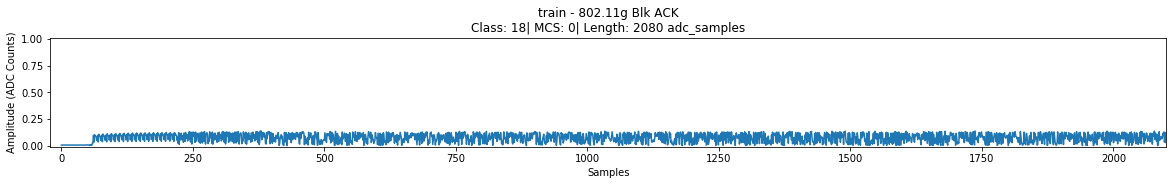

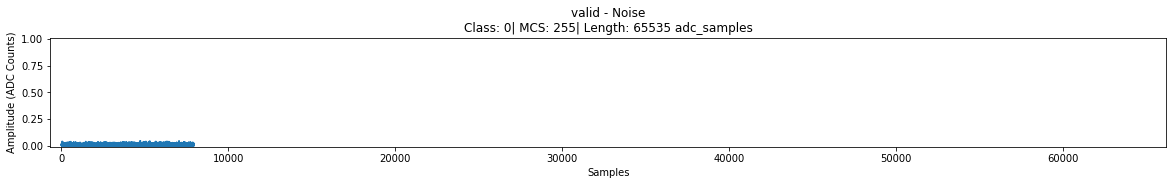

In [14]:
# Load Training and Validation data from Data Block 'file_idx'
is_verbose = True
show_plot = True
downsample_rate = 1
block = 0

dataset_type = 'train'
x_train, y_train, data_len_train, data_rate_train,\
= load_presegmented_dataset(dataset_type, CLASSIFICATION_TYPE, downsample_rate,\
                            block, is_verbose, show_plot)

dataset_type = 'valid'
x_valid, y_valid, data_len_valid, data_rate_valid,\
= load_presegmented_dataset(dataset_type, CLASSIFICATION_TYPE, downsample_rate,\
                            block, is_verbose, show_plot)

# dataset_type = 'test'
# x_test, y_test, data_len_test, data_rate_test,\
# = load_presegmented_dataset(dataset_type, CLASSIFICATION_TYPE, downsample_rate,\
#                             block, is_verbose, show_plot)
# print('x_test shape = {}| y_test shape = {}'.format(x_test.shape, y_test.shape))

x_train, y_train, data_len_train, data_rate_train =\
    data_utils.unison_shuffled_copies(x_train, y_train,\
                                      data_len_train, data_rate_train)
print('x_train shape = {}| y_train shape = {}'.format(x_train.shape, y_train.shape))

x_valid, y_valid, data_len_valid, data_rate_valid =\
    data_utils.unison_shuffled_copies(x_valid, y_valid,\
                                      data_len_valid, data_rate_valid)
print('x_valid shape = {}| y_valid shape = {}'.format(x_valid.shape, y_valid.shape))

## Training on Single Set of Hyperparameters - Single Data Block Load

In [ ]:
# 2019-11-22 - File Size: 22.364KB - seq len: 74| lr: 0.000911| dropout: 0.0158| batch_size: 68| logits_scaling: none| scaling_slope: 1.0
#    cnn_n_filters: 1| cnn_kernel_size: 10| cnn_pool_size: 2    
# 2019-11-22 - File Size: 31.990KB - seq len: 118| lr: 0.003025| dropout: 0.0066| batch_size: 66| logits_scaling: none| scaling_slope: 1.0
#     cnn_n_filters: 1| cnn_kernel_size: 10| cnn_pool_size: 1   
# 2019-11-22 - File Size: 64.108KB - seq len: 136| lr: 0.003213| dropout: 0.0203| batch_size: 64| logits_scaling: none| scaling_slope: 1.0
#     cnn_n_filters: 2| cnn_kernel_size: 10| cnn_pool_size: 1  
#  2019-11-22 -File Size: 56.476KB - seq len: 230| lr: 0.001217| dropout: 0.0704| batch_size: 62| logits_scaling: none| scaling_slope: 1.0
# 2019-11-22 - File Size: 105.030KB - cnn_n_filters: 1| cnn_kernel_size: 9| cnn_pool_size: 2
#     seq len: 450| lr: 0.018581| dropout: 0.0960| batch_size: 68| logits_scaling: none| scaling_slope: 1.0
#     cnn_n_filters: 1| cnn_kernel_size: 7| cnn_pool_size: 1  
# 2019-12-26 - Stripped Model Size: 243.383KB - ACC: .891 - seq len: 256| lr: 0.000795| dropout: 0.1163| batch_size: 64
#     cnn_n_filters: 9| cnn_kernel_size: 9| cnn_pool_size: 10                              
#     rnn_type: LSTM| rnn_layers: 1| rnn_len: 78      
# 2019-12-26 - Stripped Model Size: 107.289KB - ACC: .881 - seq len: 256| lr: 0.002828| dropout: 0.4331| batch_size: 64
#     cnn_n_filters: 2| cnn_kernel_size: 9| cnn_pool_size: 6                                 
#     rnn_type: LSTM| rnn_layers: 1| rnn_len: 48
BATCH_SIZE = 64
SEQUENCE_LENGTH = 256 #int(n_adc_samples/4) # n_adc_samples # 2554 # int(n_adc_samples) # = np.size(x_train_unshuffled, 1)
DROPOUT = 0.2250 # drop_out_list = [0.0, 0.25] #[0.0, 0.1, 0.2, 0.5]
LEARNING_RATE = 0.000375 # learning_rate_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
NO_IMPROVEMENT_LIMIT = 10
MAX_EPOCHS = 1000
PRUNING_START_BATCH = 2000

is_training = True
nn_type = 'cnn_2layer' #'cnn_1layer' #cnn_2layer #rnn #cnn-rnn

cnn_n_filters = 1
cnn_kernel_size = 20
cnn_pool_size = 5

cnn_n_filters_2 = 1
cnn_kernel_size_2 = 19
cnn_pool_size_2 = 1

rnn_type = 'LSTM' # rnn_type_list = ['LSTM', 'GRU', 'RNN']
n_rnn_stack = 1 # n_layers_list = [1,3,5,7]
rnn_len = 32 # rnn_len_list = [128, 256, 512, 1024]

optimization_parameter = 'loss'

nn_v19 = nn_classification_model_v19(BATCH_SIZE, SEQUENCE_LENGTH,\
            CLASSIFICATION_TYPE, N_CLASSIFICATIONS, DROPOUT, LEARNING_RATE,\
            is_training, nn_type, MAX_EPOCHS,\
            cnn_n_filters, cnn_kernel_size, cnn_pool_size,\
            cnn_n_filters_2, cnn_kernel_size_2, cnn_pool_size_2,\
            rnn_type, n_rnn_stack, rnn_len)

if nn_type == 'cnn_1layer':
    nn_v19.build_cnn_1layer_model_v00()
elif nn_type == 'cnn_2layer':
    nn_v19.build_cnn_2layer_model_v00()
elif nn_type == 'rnn':
    nn_v19.build_rnn_model_v00()
elif nn_type == 'cnn-rnn':
    nn_v19.build_cnn_to_rnn_model_v00()
else:
   raise Exception('[{}] is not a valid network'.format(nn_type))

keras_verbose = False
batch_size_limit = int(np.size(y_train, 0))
print('Training Block Batch Count: {}'.format(batch_size_limit))
training_history, file_bytes  =\
    nn_v19.train_v00(N_DATASET_BLOCKS, optimization_parameter,\
        NO_IMPROVEMENT_LIMIT, x_train[0:batch_size_limit, PADDING:PADDING+SEQUENCE_LENGTH],\
        y_train[0:batch_size_limit], data_len_train[0:batch_size_limit],\
        data_rate_train[0:batch_size_limit], x_valid[:, PADDING:PADDING+SEQUENCE_LENGTH],\
        y_valid, data_len_valid, data_rate_valid, keras_verbose)

K.clear_session()
tf.keras.backend.clear_session()
del nn_v19

## Training on Single Set of Hyperparameters - Continuous Data Block Load

In [ ]:
# # 2019-06-28-0116: 'loss': 0.0927734375, 'epochs': 5, 'metrics': {'accuracy': 0.90722656}}
# # TPE best: {'BATCH_SIZE': 56.0, 'DROPOUT': 0.3841959763303179, 'LEARNING_RATE': 0.0021651506653211235, 'cnn_kernel_size': 5.0, 'cnn_n_filters': 16.0, 'cnn_pool_size': 2.0, 'seq_len': 2084.0}
# #     CNN| Seq Len: 852| LR: 0.003010| DO: 0.2582| b_size: 48| logits_scaling: none| scaling_slope: 1.0| cnn_n_filters: 5| cnn_kernel_size: 9| cnn_pool_size: 1| cnn_n_filters_2: 5| cnn_kernel_size_2: 3| cnn_pool_size_2: 2
# BATCH_SIZE = 64
# SEQUENCE_LENGTH = 852 #int(n_adc_samples/4) # n_adc_samples # 2554 # int(n_adc_samples) # = np.size(x_train_unshuffled, 1)
# NO_IMPROVEMENT_LIMIT = 5 # N_EPOCHS without improvement
# DROPOUT = 0.2582 # drop_out_list = [0.0, 0.25] #[0.0, 0.1, 0.2, 0.5]
# LEARNING_RATE = 0.003010 # learning_rate_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

# logits_scaling = 'none' # logits_scaling_list['none', 'increasing linear', 'decreasing linear', 'increasing exp', 'decreasing exp']
# scaling_slope = 1.0 # scaling_slope_list[1, 2, 3, 5, 7, 11]
# is_training = True
# nn_type = 'cnn-rnn' #cnn_2layer #rnn #cnn-rnn

# cnn_n_filters = 9
# cnn_kernel_size = 5
# cnn_pool_size = 2

# cnn_n_filters_2 = 5
# cnn_kernel_size_2 = 7
# cnn_pool_size_2 = 2

# rnn_type = 'LSTM' # rnn_type_list = ['LSTM', 'GRU', 'RNN']
# n_rnn_stack = 1 # n_layers_list = [1,3,5,7]
# rnn_len = 32 # rnn_len_list = [128, 256, 512, 1024]

# optimization_parameter = 'loss'
# nn_v19 = nn_classification_model_v19(BATCH_SIZE, SEQUENCE_LENGTH,\
#             CLASSIFICATION_TYPE, N_CLASSIFICATIONS, DROPOUT, LEARNING_RATE,\
#             is_training, nn_type, MAX_EPOCHS,
#             cnn_n_filters, cnn_kernel_size, cnn_pool_size,\
#             cnn_n_filters_2, cnn_kernel_size_2, cnn_pool_size_2,\
#             rnn_type, n_rnn_stack, rnn_len)

# if nn_type == 'cnn_1layer':
#     nn_v19.build_cnn_1layer_model_v00()
# elif nn_type == 'cnn_2layer':
#     nn_v19.build_cnn_2layer_model_v00()
# elif nn_type == 'rnn':
#     nn_v19.build_rnn_model_v00()
# elif nn_type == 'cnn-rnn':
#     nn_v19.build_cnn_to_rnn_model_v00()
# else:
#    raise Exception('[{}] is not a valid network'.format(nn_type))

# batch_size_limit = int(np.size(y_train, 0))
# print('Training Block Batch Count: {}'.format(batch_size_limit))
# loss, accuracy, epochs, file_bytes  = nn_v19.train_v01(N_DATASET_BLOCKS, optimization_parameter, NO_IMPROVEMENT_LIMIT)

## Hyperopt - Single Data Block

In [16]:
from numba import cuda

n_adc_samples = 852 #N_ADC_SAMPLES
BATCH_SIZE = 64
SEQUENCE_LENGTH = 256 # n_adc_samples # = np.size(x_train_unshuffled, 1)
EPOCHS = 5
DROPOUT = 0.225 # drop_out_list = [0.0, 0.25] #[0.0, 0.1, 0.2, 0.5]
LEARNING_RATE = 0.000375 # learning_rate_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
CNN_N_FILTERS  = 1
CNN_N_FILTERS_2 = 1

rnn_type = 'LSTM' # 
rnn_type_list = ['LSTM', 'GRU', 'RNN']

is_training = True

NN_TYPE = 'cnn_2layer'#'cnn-rnn' #'cnn_1layer' #cnn_2layer #rnn

NO_IMPROVEMENT_LIMIT = 5
MAX_EPOCHS = 500
OPTIMIZATION_TARGET = 'loss'
N_MODEL_HP_VARIATIONS_TO_TEST = 100

HYPEROPT_EARLY_EXIT = True
IS_PARAM_MAXED = False
PREVIOUS_BEST_ACCURACY = 0

# Used for plotting features vs ACC/Deployed File Size
accuracy_list = []
file_size_list = []
seq_len_list = []
dropout_list = []
learning_rate_list = []
cnn_n_filters_list = []                                        
cnn_kernel_size_list = []
cnn_pool_size_list = []
cnn_n_filters_2_list = []
cnn_kernel_size_2_list = []
cnn_pool_size_2_list = []
rnn_type_list = []
n_rnn_stack_list = []
rnn_len_list = []

class HyperParams(object):
    def __init__(self, seq_len=None, learning_rate=None,\
                 dropout=None, batch_size=None, logits_scaling=None, scaling_slope=None,\
                 nn_type=None, cnn_n_filters=None, cnn_kernel_size=None, cnn_pool_size=None,
                 cnn_n_filters_2=None, cnn_kernel_size_2=None, cnn_pool_size_2=None,
                 rnn_type=None, n_rnn_stack=None, rnn_len=None):
        self.seq_len = SEQUENCE_LENGTH if seq_len is None else int(seq_len)
        self.learning_rate = LEARNING_RATE if learning_rate is None else learning_rate
        self.dropout = DROPOUT if dropout is None else dropout
        self.batch_size = BATCH_SIZE if batch_size is None else int(batch_size)
        self.logits_scaling = 'none' if logits_scaling is None else logits_scaling
        self.scaling_slope = 1.0 if scaling_slope is None else scaling_slope
        self.nn_type = NN_TYPE if nn_type is None else nn_type
        self.cnn_n_filters = CNN_N_FILTERS if cnn_n_filters is None else int(cnn_n_filters)
        self.cnn_kernel_size = 3 if cnn_kernel_size is None else int(cnn_kernel_size)
        self.cnn_pool_size = 2 if cnn_pool_size is None else int(cnn_pool_size)
        self.cnn_n_filters_2 = CNN_N_FILTERS_2 if cnn_n_filters_2 is None else int(cnn_n_filters_2)
        self.cnn_kernel_size_2 = 3 if cnn_kernel_size_2 is None else int(cnn_kernel_size_2)
        self.cnn_pool_size_2 = 2 if cnn_pool_size_2 is None else int(cnn_pool_size_2)
        self.rnn_type = 'LSTM' if rnn_type is None else rnn_type
        self.n_rnn_stack = 1 if n_rnn_stack is None else int(n_rnn_stack)
        self.rnn_len = 32 if rnn_len is None else int(rnn_len)

    def to_string(self):
        print('    **********************************************    \n')
        print('Hyperopt Settings:\n    seq len: {}| lr: {:.6f}| dropout: {:.4f}| batch_size: {}'\
              .format(self.seq_len, self.learning_rate, self.dropout, self.batch_size))
        
        if self.nn_type == 'cnn_1layer' or self.nn_type == 'cnn_2layer' or self.nn_type == 'cnn-rnn':
            print('    cnn_n_filters: {}| cnn_kernel_size: {}| cnn_pool_size: {}'\
                  .format(self.cnn_n_filters, self.cnn_kernel_size, self.cnn_pool_size))
            
        if self.nn_type == 'cnn_2layer':
            print('    cnn_n_filters_2: {}| cnn_kernel_size_2: {}| cnn_pool_size_2: {}'\
                  .format(self.cnn_n_filters_2, self.cnn_kernel_size_2, self.cnn_pool_size_2))
        elif self.nn_type == 'rnn' or self.nn_type == 'cnn-rnn':
            print('    rnn_type: {}| rnn_layers: {}| rnn_len: {}'\
                  .format(self.rnn_type, self.n_rnn_stack, self.rnn_len))

def optimizer(args):
    global x_train, y_train, data_len_train, data_rate_train
    global x_valid, y_valid, data_len_valid, data_rate_valid
    
    global file_size_list, seq_len_list, dropout_list, lr_list
    global cnn_n_filters_list, cnn_kernel_size_list, cnn_pool_size_list
    global cnn_n_filters_2_list, cnn_kernel_size_2_list, cnn_pool_size_2_list
    global accuracy_list
    
    hyper = HyperParams(**args)
    hyper.to_string()
    
    nn_v19 =\
        nn_classification_model_v19(
            hyper.batch_size, hyper.seq_len, CLASSIFICATION_TYPE,\
            N_CLASSIFICATIONS, hyper.dropout, hyper.learning_rate,\
            is_training, hyper.nn_type, MAX_EPOCHS,\
            hyper.cnn_n_filters, hyper.cnn_kernel_size, hyper.cnn_pool_size,\
            hyper.cnn_n_filters_2, hyper.cnn_kernel_size_2,\
            hyper.cnn_pool_size_2, hyper.rnn_type, hyper.n_rnn_stack,\
            hyper.rnn_len)

    if hyper.nn_type == 'cnn_1layer':
        nn_v19.build_cnn_1layer_model_v00()
    elif hyper.nn_type == 'cnn_2layer':
        nn_v19.build_cnn_2layer_model_v00()
    elif hyper.nn_type == 'rnn':
        nn_v19.build_rnn_model_v00()
    elif hyper.nn_type == 'cnn-rnn':
        nn_v19.build_cnn_to_rnn_model_v00()
    else:
       raise Exception('[{}] is not a valid network'.format(nn_type))
        
    optimization_parameter = 'loss'

    # Used for plotting features vs ACC/Deployed File Size
    seq_len_list.append(hyper.seq_len)
    dropout_list.append(hyper.dropout)
    learning_rate_list.append(hyper.learning_rate)
    
    # Appending data to appropriate lists
    if hyper.nn_type == 'cnn_1layer' or hyper.nn_type == 'cnn_2layer' or hyper.nn_type == 'cnn-rnn':
        cnn_n_filters_list.append(hyper.cnn_n_filters)                                       
        cnn_kernel_size_list.append(hyper.cnn_kernel_size)
        cnn_pool_size_list.append(hyper.cnn_pool_size)
    if hyper.nn_type == 'cnn_2layer':
        cnn_n_filters_2_list.append(hyper.cnn_n_filters_2)
        cnn_kernel_size_2_list.append(hyper.cnn_kernel_size_2)
        cnn_pool_size_2_list.append(hyper.cnn_pool_size_2)
    elif hyper.nn_type == 'rnn'  or hyper.nn_type == 'cnn-rnn':
        rnn_type_list.append(hyper.rnn_type)
        n_rnn_stack_list.append(hyper.n_rnn_stack)
        rnn_len_list.append(hyper.rnn_len)

    keras_verbose = False
    batch_size_limit = int(np.size(y_train, 0))
    print('Training Block Batch Count: {}'.format(batch_size_limit))
    training_history, file_bytes  =\
        nn_v19.train_v00(N_DATASET_BLOCKS, optimization_parameter,\
            NO_IMPROVEMENT_LIMIT, x_train[0:batch_size_limit, PADDING:PADDING+hyper.seq_len],\
            y_train[0:batch_size_limit], data_len_train[0:batch_size_limit],\
            data_rate_train[0:batch_size_limit], x_valid[:, PADDING:PADDING+hyper.seq_len],\
            y_valid, data_len_valid, data_rate_valid, keras_verbose)
    
    final_loss = training_history.history['loss'][-1]
    weighted_loss = final_loss*(file_bytes/(100*1024)) # Want model smaller than 100KB
    epochs = np.size(training_history.history['loss'],0)
    final_acc = training_history.history['sparse_categorical_accuracy'][-1]
    
    file_size_list.append(file_bytes)
    accuracy_list.append(final_acc)
    
    if epochs >= MAX_EPOCHS-1:
        print('!!! Still Training! Weighted Loss = {}'.format(weighted_loss))
    
#     if final_acc > 0.7:
    opt_status = STATUS_OK
#     else:
#         opt_status = STATUS_FAIL
#         print('\n!!! Accuracy Fail: {:.6f} !!!\n'.format(final_acc))
            
    if OPTIMIZATION_TARGET == 'loss':
        return_struct = {
                        'status': opt_status,
                        'loss': weighted_loss,
                        'epochs': epochs,
                        'metrics': {
                            'accuracy': final_acc
                            }
                        }
    elif OPTIMIZATION_TARGET == 'accuracy':
        return_struct = {
                        'status': opt_status,
                        'loss': 1-final_acc,
                        'epochs': epochs,
                        'metrics': {
                            'accuracy': final_acc
                            }
                        }
    # Cleaning memory
    del nn_v19
    sleep(5)
    K.clear_session()   
    sleep(10)
    
    return return_struct
'''
------------------------------------------------------------
Hyperparameters to sweep
'''
if NN_TYPE == 'cnn_1layer':
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
        'dropout': hp.uniform('dropout', 0, 0.5),
#         'batch_size': hp.quniform('batch_size', 32, 80, 2),
        'seq_len': hp.quniform('seq_len', 32, N_ADC_SAMPLES/4, 2),
        'cnn_n_filters': hp.quniform('cnn_n_filters', 1, 10, 1),
        'cnn_kernel_size': hp.quniform('cnn_kernel_size', 1, 20, 1),
        'cnn_pool_size': hp.quniform('cnn_pool_size', 1, 10, 1)
        }
elif NN_TYPE == 'cnn_2layer':
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
        'dropout': hp.uniform('dropout', 0, 0.5),
        'batch_size': hp.quniform('batch_size', 32, 128, 2),
        'seq_len': hp.quniform('seq_len', 128, 1024, 2), # N_ADC_SAMPLES/4, 2),
        'cnn_n_filters': hp.quniform('cnn_n_filters', 1, 3, 1),
        'cnn_kernel_size': hp.quniform('cnn_kernel_size', 1, 100, 1),
        'cnn_pool_size': hp.quniform('cnn_pool_size', 1, 10, 1),
        'cnn_n_filters_2': hp.quniform('cnn_n_filters_2', 1, 3, 1),
        'cnn_kernel_size_2': hp.quniform('cnn_kernel_size_2', 1, 100, 1),
        'cnn_pool_size_2': hp.quniform('cnn_pool_size_2', 1, 10, 1)
        }
elif NN_TYPE == 'rnn':
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
        'dropout': hp.uniform('dropout', 0, 0.5),
#         'batch_size': hp.quniform('batch_size', 32, 64, 2),
        'seq_len': hp.quniform('seq_len', 32, 2500, 2),
#         'rnn_type': hp.choice('rnn_type', rnn_type_list),
        'n_rnn_stack': hp.quniform('n_rnn_stack', 1, 10, 1),
        'rnn_len': hp.quniform('rnn_len', 16, 128, 2)
        }
elif NN_TYPE == 'cnn-rnn':
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
        'dropout': hp.uniform('dropout', 0, 0.5),
#         'batch_size': hp.quniform('batch_size', 32, 64, 2),
#         'seq_len': hp.quniform('seq_len', 128, 2500, 2),
        'cnn_n_filters': hp.quniform('cnn_n_filters', 1, 20, 1),
        'cnn_kernel_size': hp.quniform('cnn_kernel_size', 1, 10, 1),
        'cnn_pool_size': hp.quniform('cnn_pool_size', 1, 10, 1),
        #         'rnn_type': hp.choice('rnn_type', rnn_type_list),
#         'n_rnn_stack': hp.quniform('n_rnn_stack', 1, 10, 1),
        'rnn_len': hp.quniform('rnn_len', 16, 128, 2)
        }

'''
------------------------------------------------------------
Hyperparameter Sweep
'''

t = Trials()
best = fmin(optimizer, space, algo=tpe.suggest, max_evals=N_MODEL_HP_VARIATIONS_TO_TEST, trials=t)
print('TPE best: {}'.format(best))

for trial in t.trials:
    print('{} --> {}'.format(trial['result'], trial['misc']['vals']))

    **********************************************    

Hyperopt Settings:                                   
    seq len: 354| lr: 0.000113| dropout: 0.0268| batch_size: 80
    cnn_n_filters: 2| cnn_kernel_size: 95| cnn_pool_size: 5
    cnn_n_filters_2: 1| cnn_kernel_size_2: 40| cnn_pool_size_2: 8
Model: "sequential_1"                                
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 260, 2)            192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 130, 2)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 130, 2)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 91, 1)             81        
____________________________________________________

                                                                                    
--- Training Epoch: 350| Loss: 0.640| Acc: 0.822 ---

                                                                                    
--- Training Epoch: 400| Loss: 0.600| Acc: 0.828 ---

                                                                                    
--- Training Epoch: 450| Loss: 0.571| Acc: 0.833 ---

                                                                                    
--- Training Epoch: 500| Loss: 0.547| Acc: 0.836 ---

                                                                                    
Stripped Model Size: 26.977KB
Final Weights Save File:                                                            
  /mnt/2ndSSD/802-11_datasets/wlan_enveloped/nn_classification_v19_final_weights.h5
Final Model Save File:                                                              
  /mnt/2ndSSD/802-11_datasets/wlan_enveloped/nn_classification_v19_final_mo

>> Classification: protocolAndPacket| # of Classifications: 28                     

>> NN Type: cnn_2layer| Seq Len: 716| LR: 0.000019| DO: 0.1726| b_size: 36         
>> cnn_n_filters: 2| cnn_kernel_size: 69| cnn_pool_size: 6                         
>> cnn_n_filters_2: 3| cnn_kernel_size_2: 47| cnn_pool_size_2: 2                   
    Tensorboard Logs Directory:                                                    
        /mnt/2ndSSD/802-11_datasets/wlan_enveloped/logs_nn_classification_v19/run-20200124075012/train
                                                                                   
---------------------------------------------------------------

                                                                                   
--- Training Epoch: 50| Loss: 1.352| Acc: 0.558 ---

                                                                                   
--- Training Epoch: 100| Loss: 0.892| Acc: 0.702 ---

                                                    

!!! Still Training! Weighted Loss = 0.10098743395786733                               
    **********************************************                                    

Hyperopt Settings:                                                                    
    seq len: 168| lr: 0.017876| dropout: 0.4645| batch_size: 100
    cnn_n_filters: 2| cnn_kernel_size: 30| cnn_pool_size: 4                           
    cnn_n_filters_2: 2| cnn_kernel_size_2: 25| cnn_pool_size_2: 7                     
Model: "sequential"                                                                   
_________________________________________________________________                     
Layer (type)                 Output Shape              Param #                        
conv1d (Conv1D)              (None, 139, 2)            62                             
_________________________________________________________________                     
max_pooling1d (MaxPooling1D) (None, 70, 2)             0        

                                                                                      
--- Training Epoch: 300| Loss: 0.349| Acc: 0.851 ---

                                                                                      
--- Training Epoch: 350| Loss: 0.338| Acc: 0.856 ---

                                                                                      
--- Training Epoch: 400| Loss: 0.328| Acc: 0.861 ---

                                                                                      
--- Training Epoch: 450| Loss: 0.320| Acc: 0.865 ---

                                                                                      
--- Training Epoch: 500| Loss: 0.313| Acc: 0.868 ---

                                                                                      
Stripped Model Size: 47.203KB
Final Weights Save File:                                                              
  /mnt/2ndSSD/802-11_datasets/wlan_enveloped/nn_classification_v19_final_weights.h5
Final M

conv1d_1 (Conv1D)            (None, 200, 3)            375                            
_________________________________________________________________                     
max_pooling1d_1 (MaxPooling1 (None, 100, 3)            0                              
_________________________________________________________________                     
dropout_1 (Dropout)          (None, 100, 3)            0                              
_________________________________________________________________                     
flatten (Flatten)            (None, 300)               0                              
_________________________________________________________________                     
dense (Dense)                (None, 28)                8428                           
Total params: 8,857                                                                   
Trainable params: 8,857                                                               
Non-trainable params: 0                    

    **********************************************                                     

Hyperopt Settings:                                                                     
    seq len: 408| lr: 0.000212| dropout: 0.0895| batch_size: 76
    cnn_n_filters: 2| cnn_kernel_size: 4| cnn_pool_size: 9                             
    cnn_n_filters_2: 2| cnn_kernel_size_2: 25| cnn_pool_size_2: 2                      
Model: "sequential"                                                                    
_________________________________________________________________                      
Layer (type)                 Output Shape              Param #                         
conv1d (Conv1D)              (None, 405, 2)            10                              
_________________________________________________________________                      
max_pooling1d (MaxPooling1D) (None, 203, 2)            0                               
_______________________________________________________

                                                                                      
Stripped Model Size: 61.430KB
Final Weights Save File:                                                              
  /mnt/2ndSSD/802-11_datasets/wlan_enveloped/nn_classification_v19_final_weights.h5
Final Model Save File:                                                                
  /mnt/2ndSSD/802-11_datasets/wlan_enveloped/nn_classification_v19_final_model.h5
                                                                                      
Final Training Epoch: 335| Loss: 0.126| Acc: 0.946


    **********************************************                                    

Hyperopt Settings:                                                                   
    seq len: 590| lr: 0.017497| dropout: 0.2600| batch_size: 48
    cnn_n_filters: 2| cnn_kernel_size: 14| cnn_pool_size: 7                          
    cnn_n_filters_2: 3| cnn_kernel_size_2: 52| cnn_pool_size_2: 5              

                                                                                     
--- Training Epoch: 100| Loss: 0.126| Acc: 0.946 ---

                                                                                     
Stripped Model Size: 39.008KB
Final Weights Save File:                                                             
  /mnt/2ndSSD/802-11_datasets/wlan_enveloped/nn_classification_v19_final_weights.h5
Final Model Save File:                                                               
  /mnt/2ndSSD/802-11_datasets/wlan_enveloped/nn_classification_v19_final_model.h5
                                                                                     
Final Training Epoch: 135| Loss: 0.117| Acc: 0.950


    **********************************************                                     

Hyperopt Settings:                                                                     
    seq len: 166| lr: 0.000041| dropout: 0.4109| batch_size: 50
    cnn_n_filters: 3| cnn_

ValueError: Negative dimension size caused by subtracting 87 from 73 for 'conv1d_1/conv1d' (op: 'Conv2D') with input shapes: [?,1,73,3], [1,87,3,2].

## Hyperopt - Single Data Block - Grid Search

In [ ]:
# n_adc_samples = n_adc_samples
# BATCH_SIZE = 128
# SEQUENCE_LENGTH = n_adc_samples # = np.size(x_train_unshuffled, 1)
# EPOCHS = 10
# DROPOUT = 0.0 # drop_out_list = [0.0, 0.25] #[0.0, 0.1, 0.2, 0.5]
# LEARNING_RATE = 0.01 # learning_rate_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
# CNN_N_FILTERS  = 5
# CNN_N_FILTERS_2 = 5

# rnn_type = 'LSTM' # 
# rnn_type_list = ['LSTM', 'GRU', 'RNN']

# logits_scaling = 'none' # logits_scaling_list = ['none', 'increasing linear', 'decreasing linear', 'increasing exp', 'decreasing exp']
# logits_scaling_list = ['none', 'decreasing linear', 'decreasing exp']
# scaling_slope = 1.0
# is_training = False

# NN_TYPE = 'cnn-rnn' #'cnn_1layer' #cnn_2layer #rnn #cnn-rnn

# NO_IMPROVEMENT_LIMIT = 3
# OPTIMIZATION_TARGET = 'loss'
# N_MODEL_HP_VARIATIONS_TO_TEST = 50

# HYPEROPT_EARLY_EXIT = True
# IS_PARAM_MAXED = False
# PREVIOUS_BEST_ACCURACY = 0

# # Used for plotting features vs ACC/Deployed File Size
# accuracy_list = []
# file_size_list = []
# seq_len_list = []
# dropout_list = []
# learning_rate_list = []
# cnn_n_filters_list = []                                        
# cnn_kernel_size_list = []
# cnn_pool_size_list = []
# cnn_n_filters_2_list = []
# cnn_kernel_size_2_list = []
# cnn_pool_size_2_list = []
# rnn_type_list = []
# n_rnn_stack_list = []
# rnn_len_list = []

# class HyperParams(object):
#     def __init__(self, seq_len=None, learning_rate=None,\
#                  dropout=None, batch_size=None, logits_scaling=None, scaling_slope=None,\
#                  nn_type=None, cnn_n_filters=None, cnn_kernel_size=None, cnn_pool_size=None,
#                  cnn_n_filters_2=None, cnn_kernel_size_2=None, cnn_pool_size_2=None,
#                  rnn_type=None, n_rnn_stack=None, rnn_len=None):
#         self.seq_len = SEQUENCE_LENGTH if seq_len is None else int(seq_len)
#         self.learning_rate = 0.001 if learning_rate is None else learning_rate
#         self.dropout = 0.5 if dropout is None else dropout
#         self.batch_size = 64 if batch_size is None else int(batch_size)
#         self.logits_scaling = 'none' if logits_scaling is None else logits_scaling
#         self.scaling_slope = 1.0 if scaling_slope is None else scaling_slope
#         self.nn_type = NN_TYPE if nn_type is None else nn_type
#         self.cnn_n_filters = CNN_N_FILTERS if cnn_n_filters is None else int(cnn_n_filters)
#         self.cnn_kernel_size = 3 if cnn_kernel_size is None else int(cnn_kernel_size)
#         self.cnn_pool_size = 2 if cnn_pool_size is None else int(cnn_pool_size)
#         self.cnn_n_filters_2 = CNN_N_FILTERS_2 if cnn_n_filters_2 is None else int(cnn_n_filters_2)
#         self.cnn_kernel_size_2 = 3 if cnn_kernel_size_2 is None else int(cnn_kernel_size_2)
#         self.cnn_pool_size_2 = 2 if cnn_pool_size_2 is None else int(cnn_pool_size_2)
#         self.rnn_type = 'LSTM' if rnn_type is None else rnn_type
#         self.n_rnn_stack = 1 if n_rnn_stack is None else int(n_rnn_stack)
#         self.rnn_len = 32 if rnn_len is None else int(rnn_len)

#     def to_string(self):
#         print('Hyperopt Settings:\n    seq len: {}| lr: {:.6f}| dropout: {:.4f}| batch_size: {}| logits_scaling: {}| scaling_slope: {}'\
#               .format(self.seq_len, self.learning_rate, self.dropout, self.batch_size, self.logits_scaling, self.scaling_slope))
        
#         if self.nn_type == 'cnn_1layer' or self.nn_type == 'cnn_2layer' or self.nn_type == 'cnn-rnn':
#             print('    cnn_n_filters: {}| cnn_kernel_size: {}| cnn_pool_size: {}'\
#                   .format(self.cnn_n_filters, self.cnn_kernel_size, self.cnn_pool_size))
            
#         if self.nn_type == 'cnn_2layer':
#             print('    cnn_n_filters_2: {}| cnn_kernel_size_2: {}| cnn_pool_size_2: {}'\
#                   .format(self.cnn_n_filters_2, self.cnn_kernel_size_2, self.cnn_pool_size_2))
#         elif self.nn_type == 'rnn' or self.nn_type == 'cnn-rnn':
#             print('    rnn_type: {}| rnn_layers: {}| rnn_len: {}'\
#                   .format(self.rnn_type, self.n_rnn_stack, self.rnn_len))

# def optimizer(args):    
#     global IS_PARAM_MAXED, HYPEROPT_EARLY_EXIT, OPTIMIZATION_TARGET, PREVIOUS_BEST_ACCURACY
#     global x_train, y_train, data_len_train, data_rate_train
#     global x_valid, y_valid, data_len_valid, data_rate_valid

#     global file_size_list, seq_len_list, dropout_list, learning_rate_list
#     global cnn_n_filters_list, cnn_kernel_size_list, cnn_pool_size_list
#     global cnn_n_filters_2_list, cnn_kernel_size_2_list, cnn_pool_size_2_list
#     global accuracy_list

#     hyper = HyperParams(**args)
#     if IS_PARAM_MAXED == False:
#         hyper.to_string()

#     if IS_PARAM_MAXED == True:
#         loss, accuracy, epochs = 128.0, 0.0, 0
#     else:
#         nn_v19 = nn_classification_model_v19(hyper.batch_size, hyper.seq_len, CLASSIFICATION_TYPE, N_CLASSIFICATIONS,\
#                                         hyper.dropout, hyper.learning_rate, hyper.logits_scaling,\
#                                         hyper.scaling_slope, is_training, hyper.nn_type,\
#                                         hyper.cnn_n_filters, hyper.cnn_kernel_size, hyper.cnn_pool_size,\
#                                         hyper.cnn_n_filters_2, hyper.cnn_kernel_size_2, hyper.cnn_pool_size_2,\
#                                         hyper.rnn_type, hyper.n_rnn_stack, hyper.rnn_len)
#         if hyper.nn_type == 'cnn_1layer':
#             nn_v19.build_cnn_1layer_model_v00()
#         elif hyper.nn_type == 'cnn_2layer':
#             nn_v19.build_cnn_2layer_model_v00()
#         elif hyper.nn_type == 'rnn':
#             nn_v19.build_rnn_model_v00()
#         elif hyper.nn_type == 'cnn-rnn':
#             nn_v19.build_cnn_to_rnn_model_v00()
#         else:
#            raise Exception('[{}] is not a valid network'.format(nn_type))

#         optimization_parameter = 'loss'

#         # Used for plotting features vs ACC/Deployed File Size
#         seq_len_list.append(hyper.seq_len)
#         dropout_list.append(hyper.dropout)
#         learning_rate_list.append(hyper.learning_rate)

#         if hyper.nn_type == 'cnn_1layer' or hyper.nn_type == 'cnn_2layer' or hyper.nn_type == 'cnn-rnn':
#             cnn_n_filters_list.append(hyper.cnn_n_filters)                                       
#             cnn_kernel_size_list.append(hyper.cnn_kernel_size)
#             cnn_pool_size_list.append(hyper.cnn_pool_size)

#         if hyper.nn_type == 'cnn_2layer':
#             cnn_n_filters_2_list.append(hyper.cnn_n_filters_2)
#             cnn_kernel_size_2_list.append(hyper.cnn_kernel_size_2)
#             cnn_pool_size_2_list.append(hyper.cnn_pool_size_2)
#         elif hyper.nn_type == 'rnn'  or hyper.nn_type == 'cnn-rnn':
#             rnn_type_list.append(hyper.rnn_type)
#             n_rnn_stack_list.append(hyper.n_rnn_stack)
#             rnn_len_list.append(hyper.rnn_len)
        
#         batch_size_limit = int(np.size(y_train, 0))
#         print('Training Block Batch Count: {}'.format(batch_size_limit))
#         loss, accuracy, epochs, file_bytes  = nn_v19.train_v00(N_DATASET_BLOCKS, OPTIMIZATION_TARGET, NO_IMPROVEMENT_LIMIT,\
#                                                     x_train[0:batch_size_limit], y_train[0:batch_size_limit], data_len_train[0:batch_size_limit], data_rate_train[0:batch_size_limit],\
#                                                     x_valid, y_valid, data_len_valid, data_rate_valid)
#         file_size_list.append(file_bytes)
#         accuracy_list.append(accuracy)

#     if HYPEROPT_EARLY_EXIT == True and IS_PARAM_MAXED == False:
#         if PREVIOUS_BEST_ACCURACY < accuracy:
#             PREVIOUS_BEST_ACCURACY = accuracy
#     if accuracy >= 1.0: # if loss <= 0.001:
#         IS_PARAM_MAXED = True

#     if OPTIMIZATION_TARGET == 'loss':
#         return_struct = {
#                         'status': STATUS_OK,
#                         'loss': loss,
#                         'epochs': epochs,
#                         'metrics': {
#                             'accuracy': accuracy
#                             }
#                         }
#     elif OPTIMIZATION_TARGET == 'accuracy':
#         return_struct = {
#                         'status': STATUS_OK,
#                         'loss': 1-accuracy,
#                         'epochs': epochs,
#                         'metrics': {
#                             'accuracy': accuracy
#                             }
#                         }
#     return return_struct
# '''
# ------------------------------------------------------------
# Hyperparameters to sweep
# '''
# if NN_TYPE == 'cnn_1layer':
#     space = {
#         'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
#         'dropout': hp.uniform('dropout', 0, 0.5),
#         'batch_size': hp.quniform('batch_size', 32, 64, 2),
#         'seq_len': hp.quniform('seq_len', 32, 2500, 2),
#         'cnn_n_filters': hp.quniform('cnn_n_filters', 1, 5, 1),
#         'cnn_kernel_size': hp.quniform('cnn_kernel_size', 1, 10, 1),
#         'cnn_pool_size': hp.quniform('cnn_pool_size', 1, 10, 1)
#         }
# elif NN_TYPE == 'cnn_2layer':
#     space = {
#         'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
#         'dropout': hp.uniform('dropout', 0, 0.5),
#         'batch_size': hp.quniform('batch_size', 32, 64, 2),
#         'seq_len': hp.quniform('seq_len', 32, 2500, 2),
#         'cnn_n_filters': hp.quniform('cnn_n_filters', 1, 5, 1),
#         'cnn_kernel_size': hp.quniform('cnn_kernel_size', 1, 10, 1),
#         'cnn_pool_size': hp.quniform('cnn_pool_size_2', 1, 10, 1),
#         'cnn_n_filters_2': hp.quniform('cnn_n_filters_2', 1, 20, 1),
#         'cnn_kernel_size_2': hp.quniform('cnn_kernel_size_2', 1, 10, 1),
#         'cnn_pool_size_2': hp.quniform('cnn_pool_size_2', 1, 10, 1)
#         }
# elif NN_TYPE == 'rnn':
#     space = {
#         'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
#         'dropout': hp.uniform('dropout', 0, 0.5),
#         'batch_size': hp.quniform('batch_size', 32, 64, 2),
#         'seq_len': hp.quniform('seq_len', 32, 2500, 2),
# #         'rnn_type': hp.choice('rnn_type', rnn_type_list),
#         'n_rnn_stack': hp.quniform('n_rnn_stack', 1, 10, 1),
#         'rnn_len': hp.quniform('rnn_len', 16, 128, 2)
#         }
# elif NN_TYPE == 'cnn-rnn':
#     space = {
#         'learning_rate': hp.loguniform('learning_rate', np.log(0.00001), np.log(0.05)),
#         'dropout': hp.uniform('dropout', 0, 0.5),
#         'batch_size': hp.quniform('batch_size', 32, 64, 2),
#         'seq_len': hp.quniform('seq_len', 128, 2500, 2),
#         'cnn_n_filters': hp.quniform('cnn_n_filters', 1, 20, 1),
#         'cnn_kernel_size': hp.quniform('cnn_kernel_size', 1, 10, 1),
#         'cnn_pool_size': hp.quniform('cnn_pool_size', 1, 10, 1),
#         #         'rnn_type': hp.choice('rnn_type', rnn_type_list),
#         'n_rnn_stack': hp.quniform('n_rnn_stack', 1, 10, 1),
#         'rnn_len': hp.quniform('rnn_len', 16, 128, 2)
#         }

# '''
# ------------------------------------------------------------
# Hyperparameter Sweep
# '''

# for CNN_N_FILTERS in list(reversed(range(20))):
#     divisor = 16
#     SEQUENCE_LENGTH = n_adc_samples_max_0
#     while divisor >= 1:
#         PREVIOUS_BEST_ACCURACY = 1.0
#         HYPEROPT_EARLY_EXIT = True
#         while PREVIOUS_BEST_ACCURACY >= 0.9:
#             PREVIOUS_BEST_ACCURACY = 0.0
#             SEQUENCE_LENGTH = int(SEQUENCE_LENGTH/divisor - 1)
#             IS_PARAM_MAXED = False
#             t = Trials()
#             best = fmin(optimizer, space, algo=tpe.suggest, max_evals=N_MODEL_HP_VARIATIONS_TO_TEST, trials=t)
#             print('TPE best: {}'.format(best))
#             print('Seq Len: {}| Best Accuracy: {}| Divisor: {}'.format(SEQUENCE_LENGTH, PREVIOUS_BEST_ACCURACY, divisor))
#             print('------------------------------------------------')
#             if PREVIOUS_BEST_ACCURACY < 0.9:
#                 SEQUENCE_LENGTH = SEQUENCE_LENGTH*divisor
#                 divisor = divisor/2

# for trial in t.trials:
#     print('{} --> {}'.format(trial['result'], trial['misc']['vals']))

## Plotting Results vs Hyperopt Features

In [ ]:
plt.figure()
plt.subplot(3,1,1)
plt.scatter(seq_len_list, accuracy_list)    
plt.ylabel('Accuracy')
plt.subplot(3,1,2)
plt.scatter(seq_len_list, np.asarray(file_size_list)/1024.0) 
plt.ylabel('File Size (KB)')
plt.subplot(3,1,3)
plt.scatter(seq_len_list, np.log10(np.asarray(accuracy_list)/np.asarray(np.asarray(file_size_list)))) 
plt.ylabel('Acc/file_size (%/B)')
plt.xlabel('seq_len')
plt.show()

plt.figure()
plt.subplot(3,1,1)
plt.scatter(dropout_list, accuracy_list)    
plt.ylabel('Accuracy')
plt.subplot(3,1,2)
plt.scatter(dropout_list, np.asarray(file_size_list)/1024.0) 
plt.ylabel('File Size (KB)')
plt.subplot(3,1,3)
plt.scatter(dropout_list, np.log10(np.asarray(accuracy_list)/np.asarray(np.asarray(file_size_list)))) 
plt.ylabel('Acc/file_size (%/B)')
plt.xlabel('dropout_list')
plt.show()

plt.figure()
plt.subplot(3,1,1)
plt.scatter(np.log10(learning_rate_list), accuracy_list)    
plt.ylabel('Accuracy')
plt.subplot(3,1,2)
plt.scatter(np.log10(learning_rate_list), np.asarray(file_size_list)/1024.0) 
plt.ylabel('File Size (KB)')
plt.subplot(3,1,3)
plt.scatter(np.log10(learning_rate_list), np.log10(np.asarray(accuracy_list)/np.asarray(np.asarray(file_size_list)))) 
plt.ylabel('Acc/file_size (%/B)')
plt.xlabel('np.log10(learning_rate_list)')
plt.show()

plt.figure()
plt.subplot(3,1,1)
plt.scatter(cnn_n_filters_list, accuracy_list)    
plt.ylabel('Accuracy')
plt.subplot(3,1,2)
plt.scatter(cnn_n_filters_list, np.asarray(file_size_list)/1024.0) 
plt.ylabel('File Size (KB)')
plt.subplot(3,1,3)
plt.scatter(cnn_n_filters_list, np.log10(np.asarray(accuracy_list)/np.asarray(np.asarray(file_size_list)))) 
plt.ylabel('Acc/file_size (%/B)')
plt.xlabel('cnn_n_filters_list')
plt.show()

plt.figure()
plt.subplot(3,1,1)
plt.scatter(cnn_kernel_size_list, accuracy_list)    
plt.ylabel('Accuracy')
plt.subplot(3,1,2)
plt.scatter(cnn_kernel_size_list, np.asarray(file_size_list)/1024.0) 
plt.ylabel('File Size (KB)')
plt.subplot(3,1,3)
plt.scatter(cnn_kernel_size_list, np.log10(np.asarray(accuracy_list)/np.asarray(np.asarray(file_size_list)))) 
plt.ylabel('Acc/file_size (%/B)')
plt.xlabel('cnn_kernel_size_list')
plt.show()

plt.figure()
plt.subplot(3,1,1)
plt.scatter(cnn_pool_size_list, accuracy_list)    
plt.ylabel('Accuracy')
plt.subplot(3,1,2)
plt.scatter(cnn_pool_size_list, np.asarray(file_size_list)/1024.0) 
plt.ylabel('File Size (KB)')
plt.subplot(3,1,3)
plt.scatter(cnn_pool_size_list, np.log10(np.asarray(accuracy_list)/np.asarray(np.asarray(file_size_list)))) 
plt.ylabel('Acc/file_size (%/B)')
plt.xlabel('cnn_pool_size_list')
plt.show()

plt.figure()
plt.subplot(3,1,1)
plt.scatter(cnn_n_filters_2_list, accuracy_list)    
plt.ylabel('Accuracy')
plt.subplot(3,1,2)
plt.scatter(cnn_n_filters_2_list, np.asarray(file_size_list)/1024.0) 
plt.ylabel('File Size (KB)')
plt.subplot(3,1,3)
plt.scatter(cnn_n_filters_2_list, np.log10(np.asarray(accuracy_list)/np.asarray(np.asarray(file_size_list)))) 
plt.ylabel('Acc/file_size (%/B)')
plt.xlabel('cnn_n_filters_2_list')
plt.show()

plt.figure()
plt.subplot(3,1,1)
plt.scatter(cnn_kernel_size_2_list, accuracy_list)    
plt.ylabel('Accuracy')
plt.subplot(3,1,2)
plt.scatter(cnn_kernel_size_2_list, np.asarray(file_size_list)/1024.0) 
plt.ylabel('File Size (KB)')
plt.subplot(3,1,3)
plt.scatter(cnn_kernel_size_2_list, np.log10(np.asarray(accuracy_list)/np.asarray(np.asarray(file_size_list)))) 
plt.ylabel('Acc/file_size (%/B)')
plt.xlabel('cnn_kernel_size_2_list')
plt.show()

plt.figure()
plt.subplot(3,1,1)
plt.scatter(cnn_pool_size_2_list, accuracy_list)    
plt.ylabel('Accuracy')
plt.subplot(3,1,2)
plt.scatter(cnn_pool_size_2_list, np.asarray(file_size_list)/1024.0) 
plt.ylabel('File Size (KB)')
plt.subplot(3,1,3)
plt.scatter(cnn_pool_size_2_list, np.log10(np.asarray(accuracy_list)/np.asarray(np.asarray(file_size_list)))) 
plt.ylabel('Acc/file_size (%/B)')
plt.xlabel('cnn_pool_size_2_list')
plt.show()

# Testing

In [ ]:
# # cnn_valid_5054935-11529 >> CNN| Seq Len: 1225| LR: 0.002223| DO: 0.0711| b_size: 126| logits_scaling: none| scaling_slope: 1.0| cnn_n_filters: 19| cnn_kernel_size: 7| cnn_pool_size: 4

# logits_scaling = 'none' # logits_scaling_list['none', 'increasing linear', 'decreasing linear', 'increasing exp', 'decreasing exp']
# scaling_slope = 1.0 # scaling_slope_list[1, 2, 3, 5, 7, 11]
# is_training = True

# cnn_n_filters = 9
# cnn_kernel_size = 5
# cnn_pool_size = 2

# cnn_n_filters_2 = 5
# cnn_kernel_size_2 = 7
# cnn_pool_size_2 = 2

# checkpoint = "/" + "cnn_valid_5083579-40525" # 'none' cnn_valid_5083763-63219
# # checkpoint = "/" + "" # 'decreasing exp'
# # checkpoint = "/" + "cnn_valid_3690586-454" # 'decreasing linear'
# meta_to_load = CHECKPOINTS_DIR + checkpoint + ".meta"
# checkpoint_to_load = CHECKPOINTS_DIR + checkpoint

# tf.reset_default_graph()

# optimization_parameter = 'accuracy'
# cnn_v19_test = nn_classification_model_v19(BATCH_SIZE, SEQUENCE_LENGTH, CLASSIFICATION_TYPE, N_CLASSIFICATIONS, DROPOUT,\
#                                       LEARNING_RATE, logits_scaling, scaling_slope,\
#                                       is_training, cnn_n_filters, cnn_kernel_size, cnn_pool_size,\
#                                       cnn_n_filters_2, cnn_kernel_size_2, cnn_pool_size_2)

# saver = tf.train.import_meta_graph(meta_to_load)
# with tf.Session() as sess:
# #     saver.restore(sess,tf.train.latest_checkpoint(CHECKPOINTS_DIR))
#     saver.restore(sess, checkpoint_to_load)        
#     print('Restored from: {}'.format(checkpoint_to_load))
#     print('Input Sequence Length: {}'.format(SEQUENCE_LENGTH))
#     threshold=0.8
#     accuracy_list, snr_list = cnn_v19_test.sample_v11(sess, N_DATASET_BLOCKS, threshold)

<h2>Testing: Determining Minimum SEQUENCE_LENGTH for 100% Accuracy</h2>

In [ ]:
# # TPE best: {'BATCH_SIZE': 30.0, 'DROPOUT': 0.733620479775405, 'LEARNING_RATE': 0.004139365777138103, 'n_layers': 3.0, 'cnn_len': 78.0}
# 6e-5 = cnn_type: LSTM| n_layers: 1| cnn_len: 32| lr: 0.001522| dropout: 0.0305| batch_size: 64| logits_scaling: decreasing exp| scaling_slope: 5.0| cnn_n_filters: 6| cnn_kernel_size: 7| cnn_pool_size: 5
# 3e-5 = cnn_type: LSTM| n_layers: 2| cnn_len: 168| lr: 0.002650| dropout: 0.0763| batch_size: 44| logits_scaling: decreasing exp| scaling_slope: 1.0| cnn_n_filters: 5| cnn_kernel_size: 6| cnn_pool_size: 3
# cnn_type: LSTM| n_layers: 2| cnn_len: 32| lr: 0.000754| dropout: 0.0809| batch_size: 70| logits_scaling: none| scaling_slope: 3.0| cnn_n_filters: 4| cnn_kernel_size: 8| cnn_pool_size: 3

# BATCH_SIZE = 64
# SEQUENCE_LENGTH = n_adc_samples # = np.size(x_train_unshuffled, 1)
# NO_IMPROVEMENT_LIMIT = 3 # N_EPOCHS without improvement
# DROPOUT = 0.2 # drop_out_list = [0.0, 0.25] #[0.0, 0.1, 0.2, 0.5]
# LEARNING_RATE = 0.0015 # learning_rate_list = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

# cnn_type = 'LSTM' # cnn_type_list = ['LSTM', 'GRU', 'cnn']
# n_layers = 1 # n_layers_list = [1,3,5,7]
# cnn_len = 32 # cnn_len_list = [128, 256, 512, 1024]
# logits_scaling = 'none' # logits_scaling_list['none', 'increasing linear', 'decreasing linear', 'increasing exp', 'decreasing exp']
# scaling_slope = 5.0 # scaling_slope_list[1, 2, 3, 5, 7, 11]
# is_training = True

# cnn_n_filters = 6
# cnn_kernel_size = 7
# cnn_pool_size = 5

# optimization_parameter = 'loss'

# cnn_v19 = cnn_classification_model_v19(BATCH_SIZE, SEQUENCE_LENGTH, N_PACKET_TYPES, cnn_len, n_layers, DROPOUT, LEARNING_RATE, cnn_type, logits_scaling, scaling_slope, is_training, cnn_n_filters, cnn_kernel_size, cnn_pool_size)

# sequence_length_list = []
# accuracy_list = []
# threshold = 0.9
# while SEQUENCE_LENGTH > 7: # Breaks at SEQUENCE_LENGTH == 7 for some reason
#     print('Input Sequence Length: {}'.format(SEQUENCE_LENGTH))
#     cnn_v19 = nn_classification_model_v19(BATCH_SIZE, SEQUENCE_LENGTH, N_PACKET_TYPES, cnn_len, n_layers, DROPOUT, LEARNING_RATE, cnn_type, logits_scaling, scaling_slope, is_training, cnn_n_filters, cnn_kernel_size, cnn_pool_size)
#     loss, accuracy, epochs  = cnn_v19.train(x_train_unshuffled[:,0:SEQUENCE_LENGTH], y_train_unshuffled, x_valid_unshuffled[:,0:SEQUENCE_LENGTH], y_valid_unshuffled, optimization_parameter, NO_IMPROVEMENT_LIMIT)
#     sequence_length_list.append(SEQUENCE_LENGTH)
#     accuracy_list.append(accuracy)
#     SEQUENCE_LENGTH = SEQUENCE_LENGTH - 1
    
# plt.figure()
# plt.plot(sequence_length_list, accuracy_list, linewidth=4)                             
# plt.title('Minimizing Input Sequence\nNecessary for Training')
# plt.xlabel('Trained Sequence Length')
# plt.ylabel('Validation Accuracy')
# plt.xlim([76, 86])
# plt.rcParams.update({'font.size': 22})
# plt.show()

<h2>Tested Network Node and Parameter Count</h2>

In [ ]:
# checkpoint = "/" + "cnn_valid_4155106-2768" # 'decreasing exp'
# meta_to_load = CHECKPOINTS_DIR + checkpoint + ".meta"
# checkpoint_to_load = CHECKPOINTS_DIR + checkpoint

# tf.reset_default_graph()

# cnn_v19_test = nn_classification_model_v19(BATCH_SIZE, SEQUENCE_LENGTH, N_PACKET_TYPES, DROPOUT, LEARNING_RATE, logits_scaling, scaling_slope, is_training, cnn_n_filters, cnn_kernel_size, cnn_pool_size)
# # graph = tf.get_default_graph()
# # with graph.as_default():
# saver = tf.train.import_meta_graph(meta_to_load)
# with tf.Session() as sess:
# #     saver.restore(sess,tf.train.latest_checkpoint(CHECKPOINTS_DIR))
#     saver.restore(sess, checkpoint_to_load)        
#     print('Restored from: {}'.format(checkpoint_to_load))
# #     threshold=0.8
# #     cnn_v19_test.sample_v02(sess, x_test_unshuffled, y_test_unshuffled, threshold, logits_scaling)
# #     print('Finished')
    
# print('\n# Nodes in Checkpoint: {}\n'.format(np.size(tf.get_default_graph().as_graph_def().node)))

# # Open TensorFlow ckpt
# reader = tf.train.NewCheckpointReader(checkpoint_to_load)

# param_map = reader.get_variable_to_shape_map()
# total_count = 0
# for k, v in param_map.items():
#     if 'Momentum' not in k and 'global_step' not in k:
#         temp = np.prod(v)
#         total_count += temp
#         print('%s: %s => %d' % (k, str(v), temp))

# print('\nTotal Param Count in Checkpoint: %d' % total_count)

# Exporting for Deployment

<h2>Freezing Graph</h2>

In [ ]:
def freeze_loaded_graph(model_save_file=MODEL_FINAL_SAVE_PATH, keep_var_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """

    K.set_learning_phase(0)#tf.keras.backend.set_learning_phase(0) # 0 testing, 1 training mode        
    sess = K.get_session()   
    
    from keras.models import load_model
    loaded_model = load_model(model_save_file) #tf.keras.models.load_model(MODEL_FINAL_SAVE_PATH)
    output_names=[out.op.name for out in loaded_model.outputs]
    input_names=[inputs_0.op.name for inputs_0 in loaded_model.inputs]

    graph = sess.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        print("Loaded Input Node: {}".format([inputs_0.op.name for inputs_0 in loaded_model.inputs]))
        print("Loaded Output Node: {}".format([outputs_0.op.name for outputs_0 in loaded_model.outputs]))
#         print("Loaded Freeze Vals: {}".format(freeze_var_names))
        print('\n---------------------------------------------------------------\n')
    
        from tensorflow.python.framework.graph_util import convert_variables_to_constants
        frozen_graph = convert_variables_to_constants(sess, input_graph_def, \
                                                      output_names, freeze_var_names)
    return frozen_graph

frozen_graph = freeze_loaded_graph(MODEL_FINAL_SAVE_PATH) # Save the frozen graph

frozen_graph_dir = CHECKPOINTS_DIR 
frozen_graph_filename = 'saved_model.pb'
tf.train.write_graph(frozen_graph, frozen_graph_dir, frozen_graph_filename, as_text=False )

# Get frozen graph file size
frozen_graph_filepath = frozen_graph_dir + '/' + frozen_graph_filename
file_bytes = int(os.path.getsize(frozen_graph_filepath))
file_size, units = data_utils.convert_bytes(file_bytes)
K.clear_session()

print('File Size: {:.3f}{}'.format(file_size, units))


<h2>Loading Frozen Graph and Counting the Nodes</h2>

In [ ]:
tf.reset_default_graph()
def load_frozen_graph(graph_dir):
    with tf.gfile.FastGFile(graph_dir, "rb") as file:
        print("Graph restored from:\n{}".format(graph_dir))
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(file.read())            
        print("\n# of Nodes in GraphDef: {}".format(np.size(graph_def.node)))

frozen_graph_dir = CHECKPOINTS_DIR 
frozen_graph_filename = 'saved_model.pb'
frozen_graph_filepath = frozen_graph_dir + '/' + frozen_graph_filename
load_frozen_graph(frozen_graph_filepath)

<h2>TFLite Conversion:</h2>

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model_file(MODEL_FINAL_SAVE_PATH)

# TFLite Version
tflite_model = converter.convert()    
with open(MODEL_TFLITE_PATH, 'wb') as f:
  f.write(tflite_model)

file_bytes = int(os.path.getsize(MODEL_TFLITE_PATH))
file_size, units = data_utils.convert_bytes(file_bytes)
print('\nTFLite File Size: {:.3f}{}'.format(file_size, units)) 

# Quantized TFLite Version
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
with open(MODEL_TFLITE_QUANT_PATH, 'wb') as f:
  f.write(tflite_quant_model)

file_bytes = int(os.path.getsize(MODEL_TFLITE_QUANT_PATH))
file_size, units = data_utils.convert_bytes(file_bytes)
print('\nTFLite Quantized File Size: {:.3f}{}'.format(file_size, units))